In [3]:
import sys
sys.path.append('/home/franciscojavier/Escritorio/TFG/scDEAL')


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import utils as ut
import glob
from sklearn.metrics import classification_report
from scipy.stats import pearsonr
from utils import de_score
import random
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')
from scipy.stats import ranksums,ttest_ind


<div class="alert alert-info">

**Note**
    
This notebook provides analysis on the umap, the performance score, and the predictive gene module score correlation. Require input is the h5ad file of the transfer learning
    
</div>  

# Set parameters of scanpy

Esa parte del código configura Scanpy para que las visualizaciones y la salida del análisis sean más limpias y claras. Te explico línea por línea:

In [5]:
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.settings.set_figure_params(dpi=300, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures

Input h5ad of trained datasets

In [4]:
# List all files in the directoty
# h5ad_list = glob.glob("F:/ws/pyws/trainsource/saved/adata/review/*.h5ad") el tiene eso, pero mi carpeta es otra, pruebo celda de abajo


In [6]:
import glob

h5ad_list = glob.glob('/home/franciscojavier/Escritorio/TFG/scDEAL/save/adata/*.h5ad')
print(h5ad_list)


['/home/franciscojavier/Escritorio/TFG/scDEAL/save/adata/GSE110894integrate_data_GSE110894_drug_I.BET.762_bottle_512_edim_256,128_pdim_128,64_model_DAE_dropout_0.1_gene_F_lr_0.5_mod_new_sam_upsampling.h5ad']


In [7]:
adata = sc.read_h5ad('/home/franciscojavier/Escritorio/TFG/scDEAL/save/adata/GSE110894integrate_data_GSE110894_drug_I.BET.762_bottle_512_edim_256,128_pdim_128,64_model_DAE_dropout_0.1_gene_F_lr_0.5_mod_new_sam_upsampling.h5ad')
print(adata.obs.columns)


Index(['Plate#', 'Well position', 'Sample name', 'Index-Sort condition',
       'Well index', 'sensitive', 'sensitivity', 'Sensitive_score',
       'Resistant_score', 'n_genes', 'n_genes_by_counts', 'total_counts',
       'total_counts_mt-', 'pct_counts_mt-', 'total_counts_rps',
       'pct_counts_rps', 'total_counts_rpl', 'pct_counts_rpl', 'leiden',
       'leiden_origin', 'sens_preds_pret', 'sens_label_pret', 'sens_preds',
       'sens_label', 'rest_preds'],
      dtype='object')


In [8]:
adata.shape

(1419, 6644)

Define cell type column name in the meta data file of each dataset:
es utilizada para especificar qué columna en los metadatos (adata.obs) de cada conjunto de datos contiene información sobre los tipos celulares (cell type) o categorías relevantes para realizar análisis posteriores.

In [12]:
CELL_TYPE_KEY = {"GSE117872_HN137":"cell_color","GSE117872_HN120":"cell_color","GSE110894":"Sample name","GSE140440":"sensitivity","GSE112274":"sensitivity",
                "GSE149383":"sensitivity"}

Select data set of interested

In [13]:
h5ad_list = [h5ad_list[0]]
print(h5ad_list)

['/home/franciscojavier/Escritorio/TFG/scDEAL/save/adata/GSE110894integrate_data_GSE110894_drug_I.BET.762_bottle_512_edim_256,128_pdim_128,64_model_DAE_dropout_0.1_gene_F_lr_0.5_mod_new_sam_upsampling.h5ad']


In [14]:
intested = "GSE110894"

SCRIPT TRAJECOTRY

In [13]:
import scanpy as sc
from trajectory import trajectory  # o cell_trajectory si lo renombraste


In [14]:
adata = sc.read_h5ad('/home/franciscojavier/Escritorio/TFG/scDEAL/save/adata/GSE149383integrate_data_GSE149383_drug_ERLOTINIB_bottle_64_edim_512,256_pdim_256,128_model_DAE_dropout_0.3_gene_F_lr_0.01_mod_new_sam_upsampling.h5ad')


In [15]:
adata.obs.columns


Index(['sensitive', 'sensitivity', 'Sensitive_score', 'Resistant_score',
       'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt-',
       'pct_counts_mt-', 'total_counts_rps', 'pct_counts_rps',
       'total_counts_rpl', 'pct_counts_rpl', 'leiden', 'leiden_origin',
       'sens_preds_pret', 'sens_label_pret', 'sens_preds', 'sens_label',
       'rest_preds'],
      dtype='object')

In [18]:
import scanpy as sc
import numpy as np
from scipy import stats

# FUNCION MODIFICADA
def trajectory(adata, now, color="leiden", root_key='sens_label', genes_vis=None, root=1, plot=False):
    sc.tl.draw_graph(adata)

    if plot:
        sc.pl.draw_graph(adata, color=['leiden','sens_label'], legend_loc='on data',
                         save="Initial_graph_" + now, show=False)

    # Diffusion map
    sc.tl.diffmap(adata)
    sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')
    sc.tl.draw_graph(adata)
    
    if plot:
        sc.pl.draw_graph(adata, color=['leiden','sens_label'], legend_loc='on data',
                         save="Diffusion_graph_" + now, show=False)

    # PAGA
    sc.tl.paga(adata, groups='leiden')
    sc.pl.paga(adata, color='leiden', save="Paga_initial" + now, show=False)
    sc.tl.draw_graph(adata, init_pos='paga')

    if plot:
        sc.pl.draw_graph(adata, color=['leiden'], legend_loc='on data',
                         save="Paga_initialization_graph" + now, show=False)
        sc.pl.paga_compare(adata, threshold=0.03, title='', right_margin=0.2, size=10,
                           edge_width_scale=0.5, legend_fontsize=12, fontsize=12,
                           frameon=False, edges=True, save="Paga_cp1" + now, show=False)

    # DPT pseudotime
    adata.uns['iroot'] = np.flatnonzero(adata.obs[root_key] == root)[0]
    sc.tl.dpt(adata)

    # Preprocesamiento para .raw
    adata_raw = adata.copy()
    sc.pp.log1p(adata_raw)
    sc.pp.scale(adata_raw)
    adata.raw = adata_raw

    if plot:
        sc.pl.draw_graph(adata, color=['sens_preds', 'Sensitive_score', 'Resistant_score', 'dpt_pseudotime'],
                         legend_loc='on data', save="Pseudotime_graph" + now, show=False)
        sc.pl.paga_compare(adata, color="dpt_pseudotime", threshold=0.03, title='', right_margin=0.2, size=10,
                           edge_width_scale=0.5, legend_fontsize=12, fontsize=12,
                           frameon=False, edges=True, save="Paga_cp2" + now, show=False)

        if genes_vis is not None:
            sc.pl.draw_graph(adata, color=genes_vis, legend_loc='on data',
                             save="Pseudotime_graph_genes" + now, show=False)

    # Trajectory con vecinos "Trans" (si existen)
    if 'X_diffmap' in adata.obsm.keys():
        try:
            sc.tl.diffmap(adata, neighbors_key="Trans")
            sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap', key_added='difftrans')
            sc.tl.draw_graph(adata, neighbors_key='difftrans')
            if plot:
                sc.pl.draw_graph(adata, color=['leiden_origin','sens_label'], legend_loc='on data',
                                 save="Diffusion_graph_trans_" + now, show=False)

            sc.tl.paga(adata, groups='leiden_origin', neighbors_key='difftrans')
            if plot:
                sc.pl.paga(adata, color=['leiden_origin'], save="Paga_trans" + now, show=False)

            sc.tl.draw_graph(adata, init_pos='paga', neighbors_key='difftrans')
            if plot:
                sc.pl.draw_graph(adata, color=['leiden_origin'], legend_loc='on data',
                                 save="Paga_trans_graph" + now, show=False)
        except:
            print("⚠️ No se pudieron usar vecinos 'Trans'.")

    # Calcular correlaciones
    correlations = {}
    keys = ['sens_preds', 'rest_preds', 'Sensitive_score', 'Resistant_score']
    for k in keys:
        if k in adata.obs.columns:
            correlations[k] = stats.spearmanr(adata.obs[k], adata.obs['dpt_pseudotime'])
        else:
            print(f"⚠️ '{k}' no existe en adata.obs")

    return adata, correlations

# CARGAR TU ARCHIVO
adata = sc.read_h5ad('/home/franciscojavier/Escritorio/TFG/scDEAL/save/adata/GSE149383integrate_data_GSE149383_drug_ERLOTINIB_bottle_64_edim_512,256_pdim_256,128_model_DAE_dropout_0.3_gene_F_lr_0.01_mod_new_sam_upsampling.h5ad')

# EJECUTAR TRAJECTORY
adata, corrs = trajectory(
    adata,
    now="erlotinib_test",
    root_key="sens_label",
    root=1,
    plot=True,
    genes_vis=None  # O ['EGFR', 'MKI67'] si quieres visualizar genes específicos
)

# MOSTRAR CORRELACIONES
print("\n📊 Correlaciones con pseudotiempo:")
for key, val in corrs.items():
    print(f"{key}: correlación = {val[0]:.3f}, p-valor = {val[1]:.3e}")


⚠️ No se pudieron usar vecinos 'Trans'.

📊 Correlaciones con pseudotiempo:
sens_preds: correlación = -0.560, p-valor = 2.177e-124
rest_preds: correlación = 0.559, p-valor = 8.509e-124
Sensitive_score: correlación = -0.577, p-valor = 2.913e-133
Resistant_score: correlación = 0.385, p-valor = 3.417e-54


In [ ]:
print(dir(ct))  # Deberías ver 'trajetory_paga' aquí


##ANALISIS PAGA

In [15]:
import sys
sys.path.append("/home/franciscojavier/Escritorio/TFG/scDEAL/scanpypip")
import preprocessing as pp


In [16]:
adata= pp.receipe_my(adata, normalize=True , log =True , remove_genes=["mt-", "rps"],
                     percent_mito=10 )

(1336, 6643)


In [20]:
import sys
sys.path.append("/home/franciscojavier/Escritorio/TFG/scDEAL/scanpypip")

import cell_trajectory as ct




In [21]:
print(dir(ct))  # Deberías ver 'trajetory_paga' aquí


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'np', 'pd', 'pl', 'pp', 'rcParams', 'sc', 'trajetory_paga']


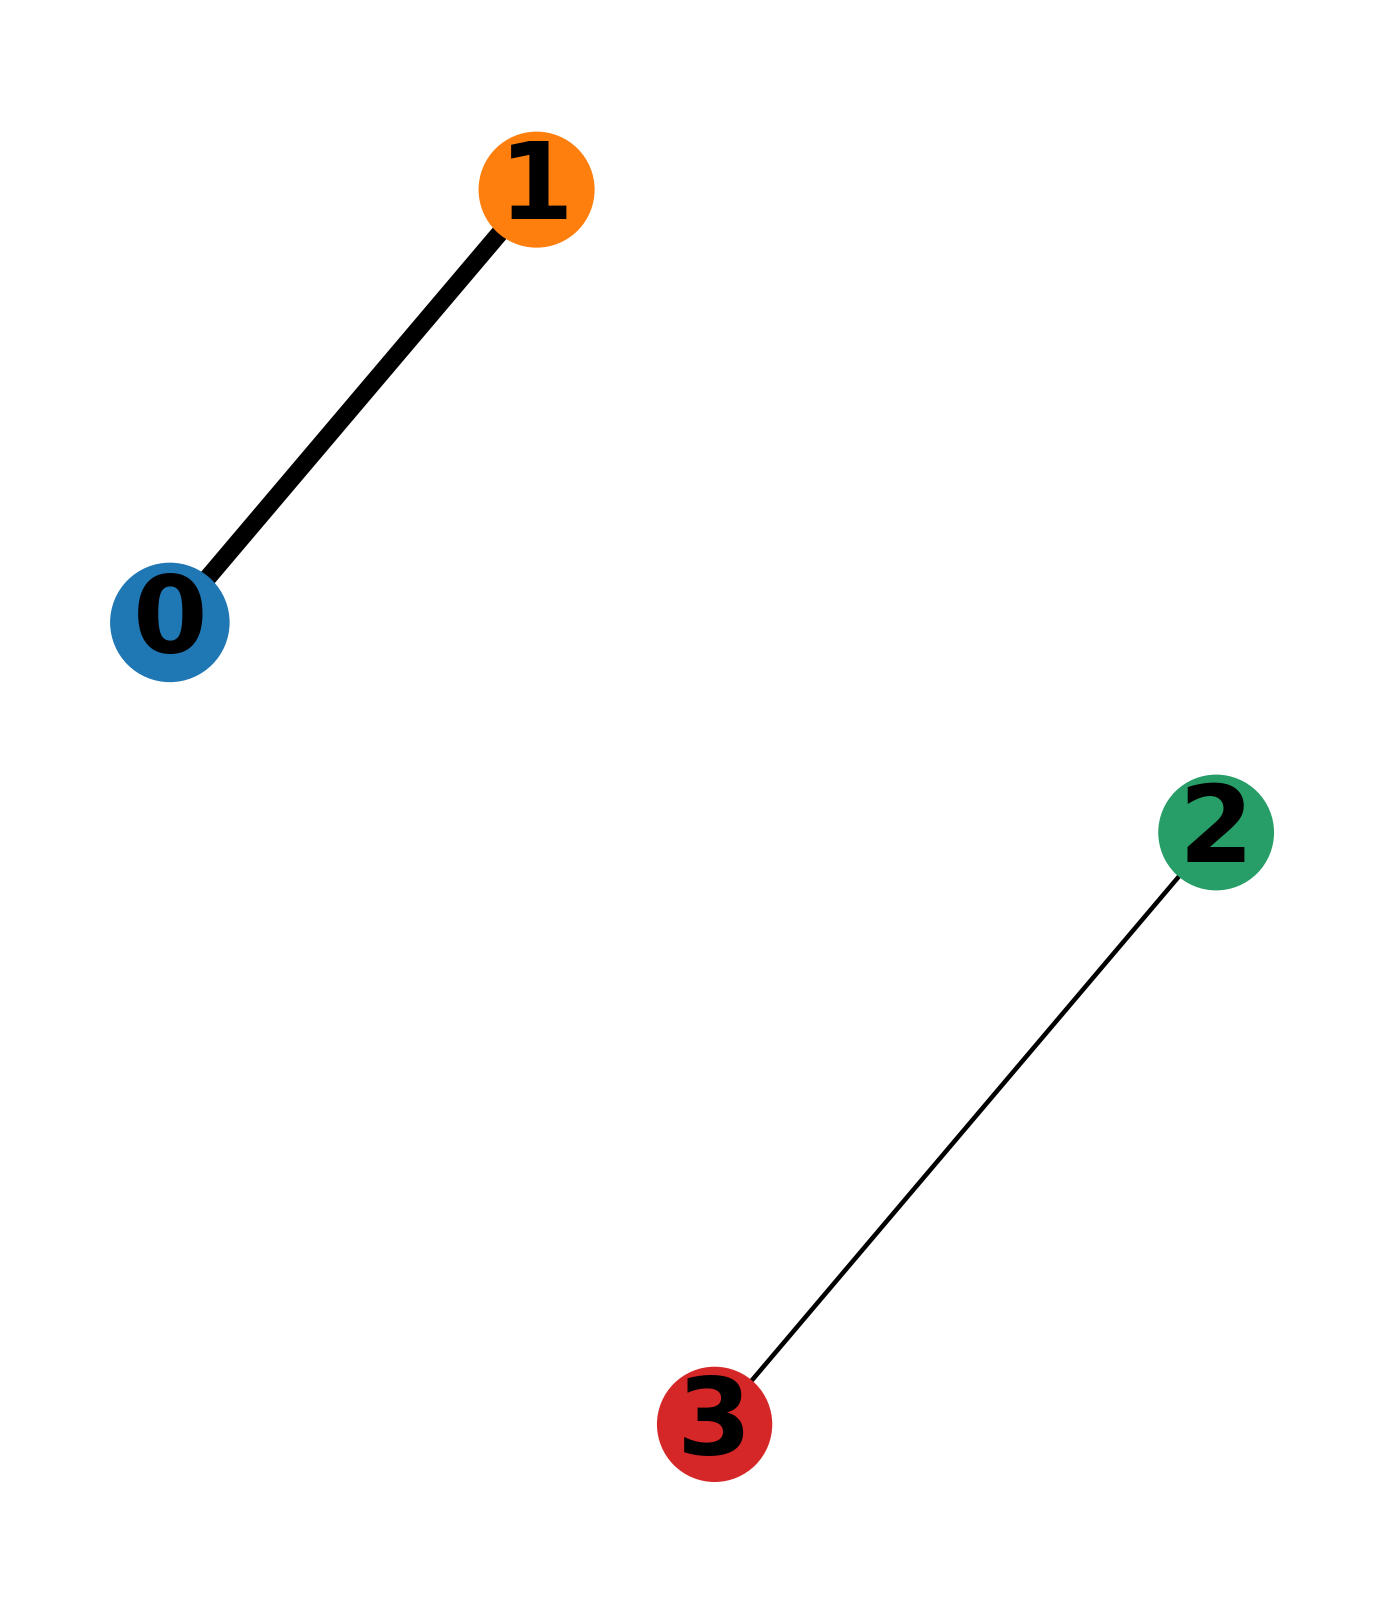

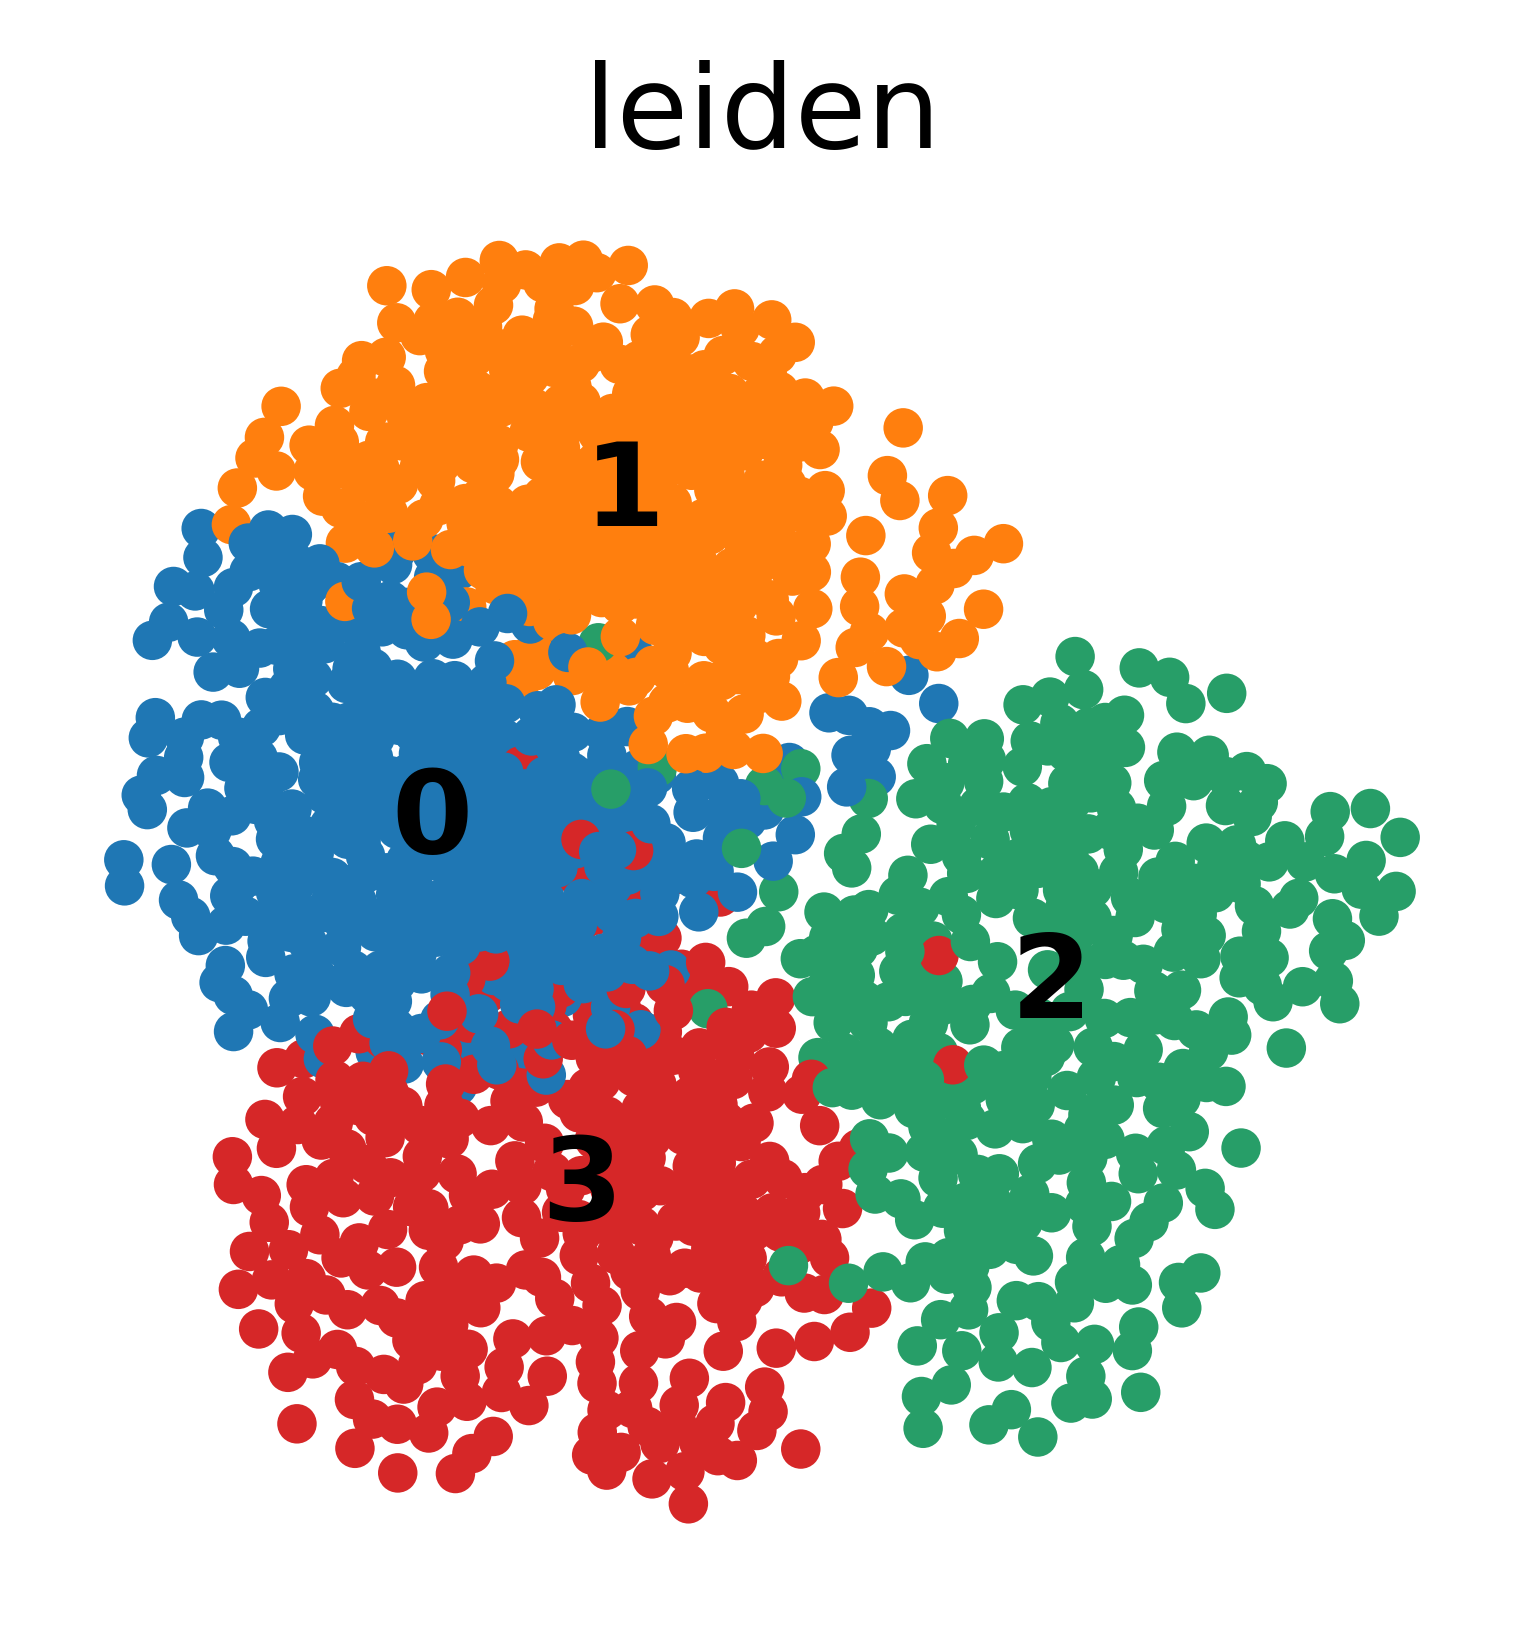

In [24]:
adata = ct.trajetory_paga(adata, clustering="leiden", n_neighbors=15)


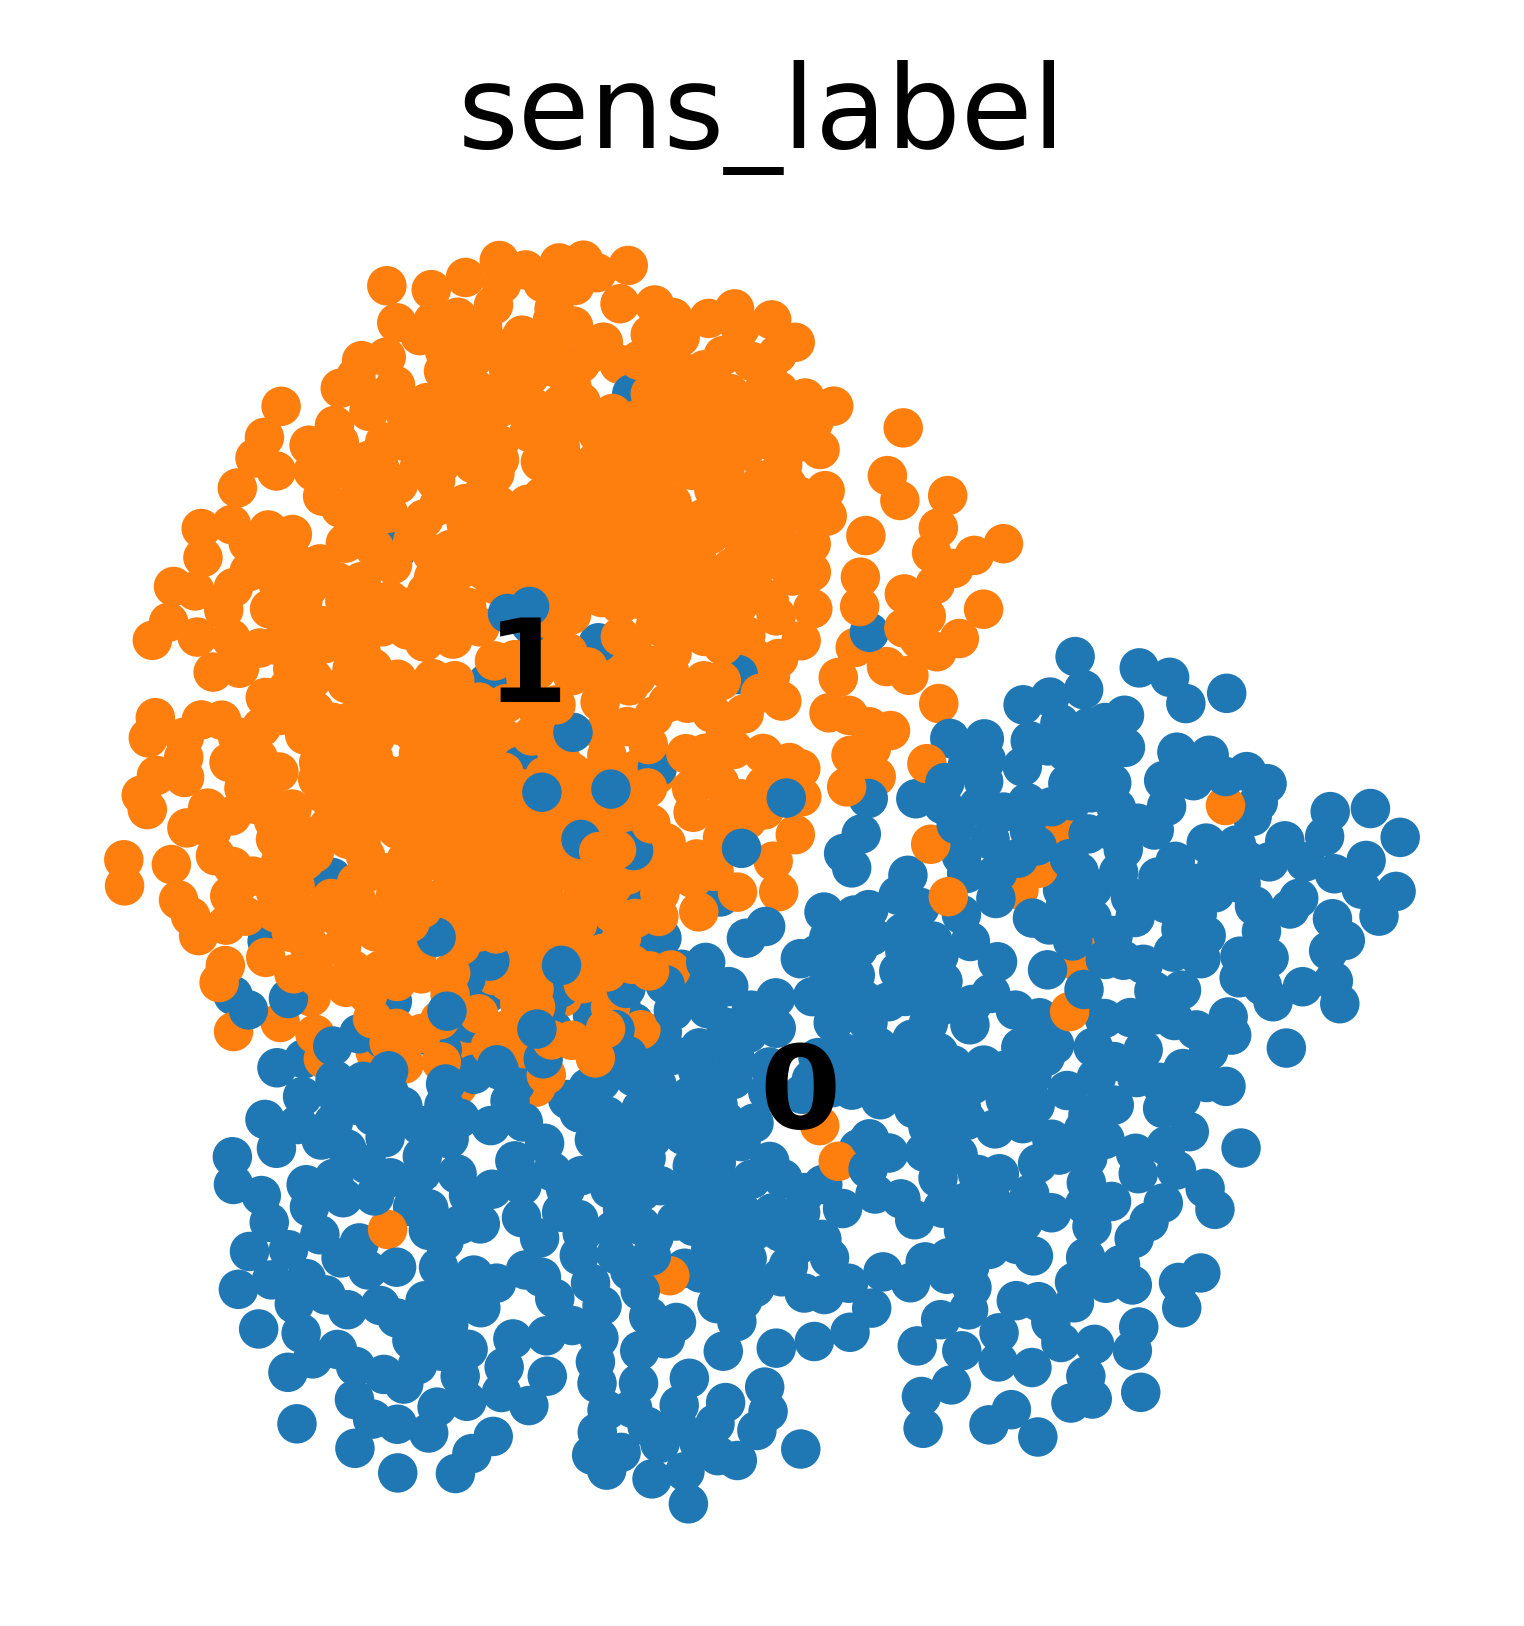

In [25]:
sc.pl.draw_graph(adata, color="sens_label", legend_loc="on data")


# Generated 3 figures comparing before, after tarnsfer, ground truth

And it will save the F1 score before and after the transfer learning

In [15]:
# Random score test
def ran_test_score(adata,n_iters=1000):
    ran_results1 = []
    ran_results2 = []

    s_score,s_pval = pearsonr(adata.obs["1_score"],adata.obs["Sensitive_score"])
    r_score,r_pval = pearsonr(adata.obs["0_score"],adata.obs["Resistant_score"])


    for i in range(0,n_iters):

        gl1 = random.sample(list(adata.var.index),50)
        adata=sc.tl.score_genes(adata, gene_list=gl1,score_name="l1_score",copy=True)

        rand_score1,rand_pval1 = pearsonr(adata.obs["l1_score"],adata.obs["Sensitive_score"])
        rand_score2,rand_pval2 = pearsonr(adata.obs["l1_score"],adata.obs["Resistant_score"])

        ran_results1.append(rand_score1)
        ran_results2.append(rand_score2)
        
        
    return adata,ran_results1, s_score,s_pval ,ran_results2,r_score,r_pval

In [16]:
# Functioin to show p value on the figure
def p_string(l,score):
    score = sum(l>=score)/len(l)
    if(score==0):
        return "p < 0.001"
    else:
        return "p =" + " "+str(score)

# Show the prediction probability before transfer and after on UMAP

In [17]:
import os
os.makedirs('saved/results', exist_ok=True)
# Esto crea automáticamente la carpeta saved/results/ si no existe.

Index(['Plate#', 'Well position', 'Sample name', 'Index-Sort condition',
       'Well index', 'sensitive', 'sensitivity', 'Sensitive_score',
       'Resistant_score', 'n_genes', 'n_genes_by_counts', 'total_counts',
       'total_counts_mt-', 'pct_counts_mt-', 'total_counts_rps',
       'pct_counts_rps', 'total_counts_rpl', 'pct_counts_rpl', 'leiden',
       'leiden_origin', 'sens_preds_pret', 'sens_label_pret', 'sens_preds',
       'sens_label', 'rest_preds'],
      dtype='object')



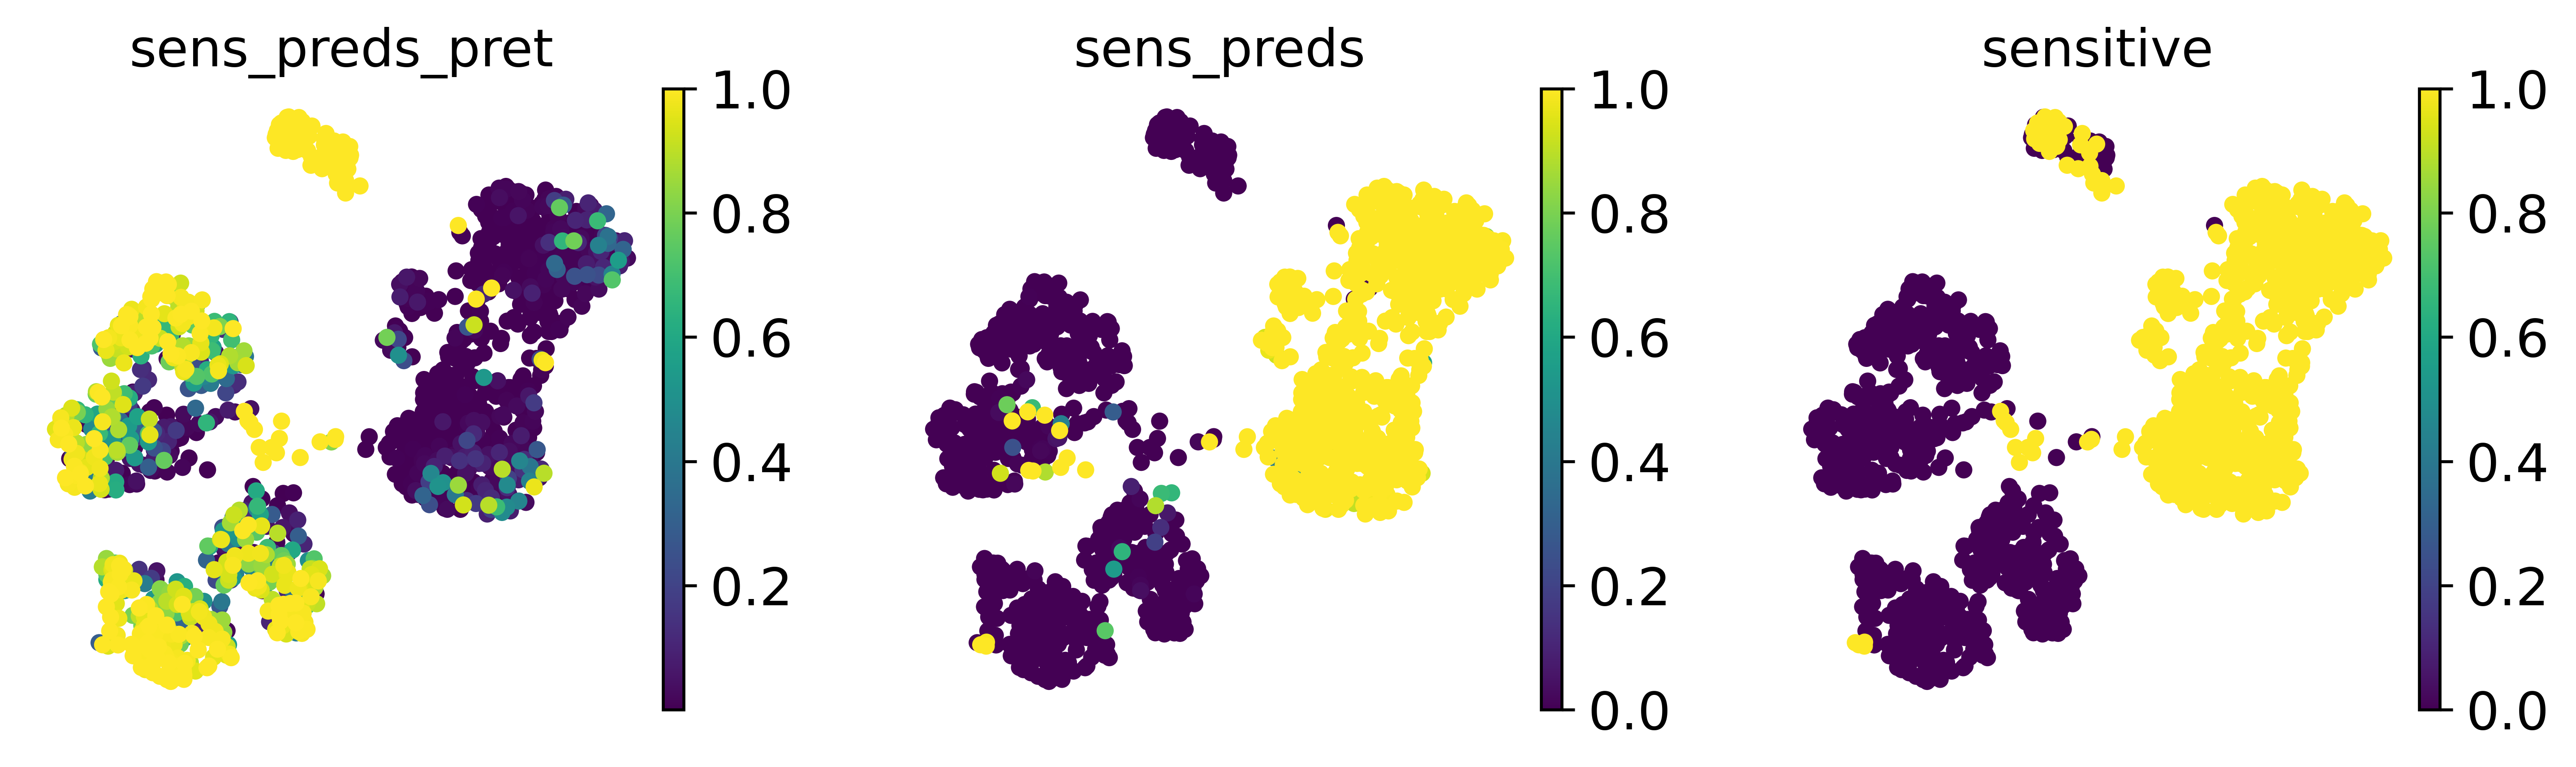

In [18]:
from sklearn.metrics import (auc, average_precision_score,
                             classification_report, mean_squared_error,
                             precision_recall_curve, r2_score, roc_auc_score)

names = []
score = []
model = []

interes_adata = None

for f in h5ad_list:
    
    
    adata = sc.read_h5ad(filename=f)
    
    
    if(f.find("117872")>0):
        adata = adata[adata.obs['cluster']!="Holiday"]

    pretrain_label = adata.obs['sens_label_pret']
    sens_label = adata.obs['sens_label']
    
        
    print(adata.obs.columns)

    grouth_truth = adata.obs['sensitive']
    sens_pb_pret = adata.obs['sens_preds_pret']
    sens_label_pret = adata.obs['sens_label_pret']
    sens_pb = adata.obs['sens_preds']

    name = f.split("1214")[0].split("/")[-1] #cambaido para linux sentido de la barra por mi

    
    if(name=="GSE110894"):
        adata=adata[(adata.obs["Sample name"] != "EMPTY") & \
                    (adata.obs["Sample name"] != "EMPTY ") ,: ]
    
    
    
    report_dict_pret = classification_report(grouth_truth, pretrain_label, output_dict=True)
    classification_report_pret_df = pd.DataFrame(report_dict_pret).T
    f1score_pret = report_dict_pret['weighted avg']['f1-score']
    ap_pret = average_precision_score(grouth_truth, sens_pb_pret)
    auroc_pret = roc_auc_score(grouth_truth, sens_label_pret)

    
    report_dict = classification_report(grouth_truth, sens_label, output_dict=True)
    classification_report_df = pd.DataFrame(report_dict).T
    f1score = report_dict['weighted avg']['f1-score']
    ap = average_precision_score(grouth_truth, sens_pb)
    auroc = roc_auc_score(grouth_truth, sens_label)
    
    names.append(name)
    score.append(f1score_pret)
    model.append("before")
    
    names.append(name)
    score.append(f1score)
    model.append("transfer")

    result = pd.DataFrame({"f1":[f1score_pret,f1score],
                          "ap":[ap_pret,ap],
                          "auroc":[auroc_pret,auroc]},index=["pretrain","transfer"])
    
    print()
    # Save the figure
    sc.pl.umap(adata,color=['sens_preds_pret','sens_preds','sensitive'],save="report_compare"+name + '.tiff')
    # Save the f1 score before and after
    result.to_csv("saved/results/report_compare"+name + '.csv')

    # Arreglo antes de de_score()
    if 'log1p' not in adata.uns:
        adata.uns['log1p'] = {'base': None}
    elif 'base' not in adata.uns['log1p']:
        adata.uns['log1p']['base'] = None
    
    # Ahora sí ejecutas el análisis de genes diferenciales
    adata = ut.de_score(adata, clustername='sens_label')

    # Cal pred senstivie score
    adata = ut.de_score(adata,clustername='sens_label')
    
    if(f.find(intested)>0):
        interes_adata = adata

 Interpretación rápida:

    Antes de la transferencia (panel izquierdo) el modelo todavía no "entiende" del todo el dominio single-cell.

    Después de la transferencia (DaNN) (panel central) el modelo ya separa mucho mejor las poblaciones.

    Ground truth (derecha) Es la verdad de terreno. Aquí se muestra cómo deberían estar clasificadas realmente las células.
    
    antes de la transferencia (sens_preds_pret):

    El modelo aún "piensa" en datos bulk y no separa bien las células individuales (todo mezclado).

Después de la transferencia (sens_preds):

    El modelo ya ha aprendido a distinguir las células individuales y la separación sensible/resistente mejora mucho.

    El color amarillo = células sensibles.

    El color morado = células resistentes.

In [63]:
adata=interes_adata

# Compare the score before and after the transfer learning

In [64]:
result_compare = pd.DataFrame({"data":names,
                      "transfer":model,
                      "score":score})

In [65]:
result_compare

data  transfer     score
0  GSE110894integrate_data_GSE110894_drug_I.BET.7...    before  0.426823
1  GSE110894integrate_data_GSE110894_drug_I.BET.7...  transfer  0.947863

Como vemos antes de la transferencia tenia una prediccion de 0.42 , luego de esta tiene una prediccion de 0,9478

# Plot the umap highlighting the wrong predictions

Con esto vemos cuantas celulas a clasificado incorrectamente

In [70]:
idx = adata.obs["sensitive"] != adata.obs["sens_label"]
#Utiliza sensitive para comparar sensibilidad predicha vs real.

In [71]:
adata.obs['wrong'] = pd.NA

In [72]:
adata.obs.loc[idx,'wrong'] = "Wrong"
adata.obs['wrong'] = adata.obs.wrong.astype('category')

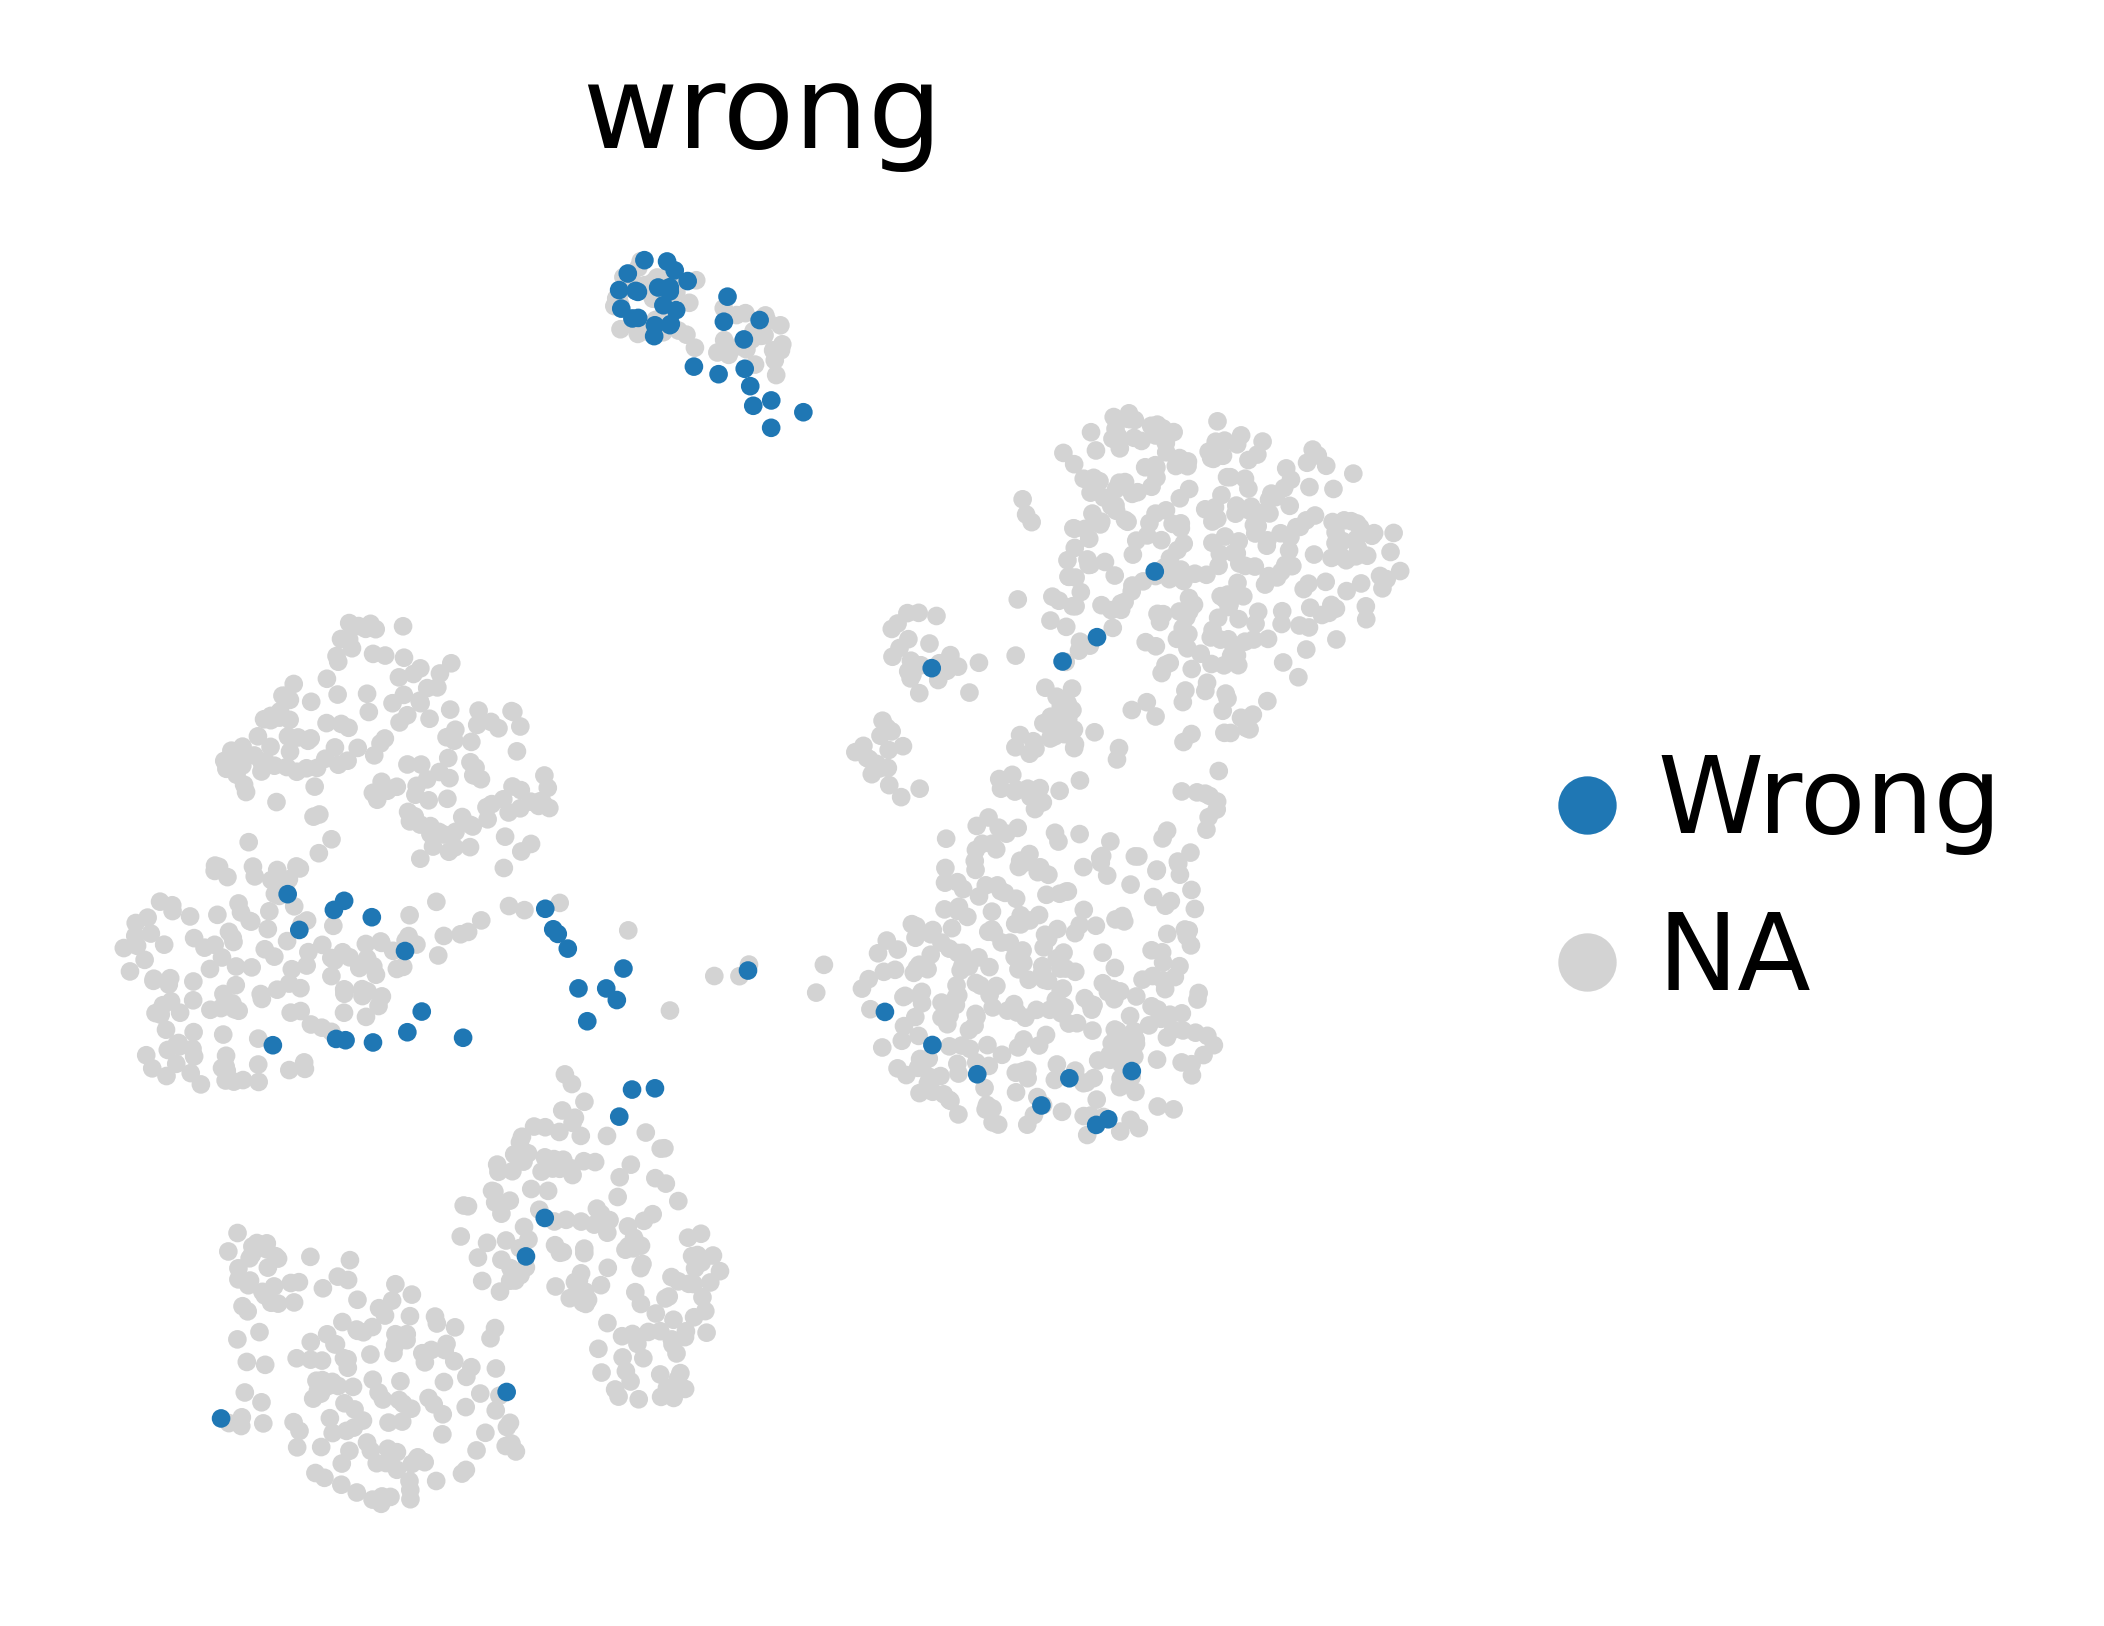

In [73]:
sc.pl.umap(adata,color="wrong",size=20)

In [74]:
name = intested

Calculate the numer of wrong predictions in each cell type

In [75]:
df = adata.obs[[CELL_TYPE_KEY[name],"wrong"]]\
.groupby([CELL_TYPE_KEY[name]])\
.aggregate(['count','size'])\
.reset_index()
df['data'] = name
df

Sample name wrong            data
                                        count size           
0                      101 CELL CONTROL     4    4  GSE110894
1                                 EMPTY    12   12  GSE110894
2                                EMPTY      3    3  GSE110894
3              MA9 IBET RESISTANT CELLS    18  345  GSE110894
4  MA9 IBET RESISTANT CELLS- WITHDRAWAL     1  340  GSE110894
5                    MA9 PARENTALS DMSO    18  372  GSE110894
6            MA9 PARENTALS IBET 400NMOL    18  343  GSE110894

Podemos ver que para la muestra MA9 IBET RESISTANT CELLS ha clasificado 18 mal de 345

# Overview comparing the prediction and the ground Truth

In [79]:
import os
os.makedirs('saved/figures', exist_ok=True)


In [82]:
print(adata.obs["pred_binary"].unique())



[0, 1]
Categories (2, int64): [0, 1]


In [83]:
# mirar columnas de mi dataset antes de hacerlo
adata.obs["pred_binary"] = adata.obs["pred_binary"].astype("category")
adata.obs["pred_binary"] = adata.obs["pred_binary"].cat.rename_categories({1:"Sensitive", 0:"Resistant"})


In [84]:
adata.obs=adata.obs.rename(columns={"sensitivity": "Ground Truth", "sens_label": "Prediction"})

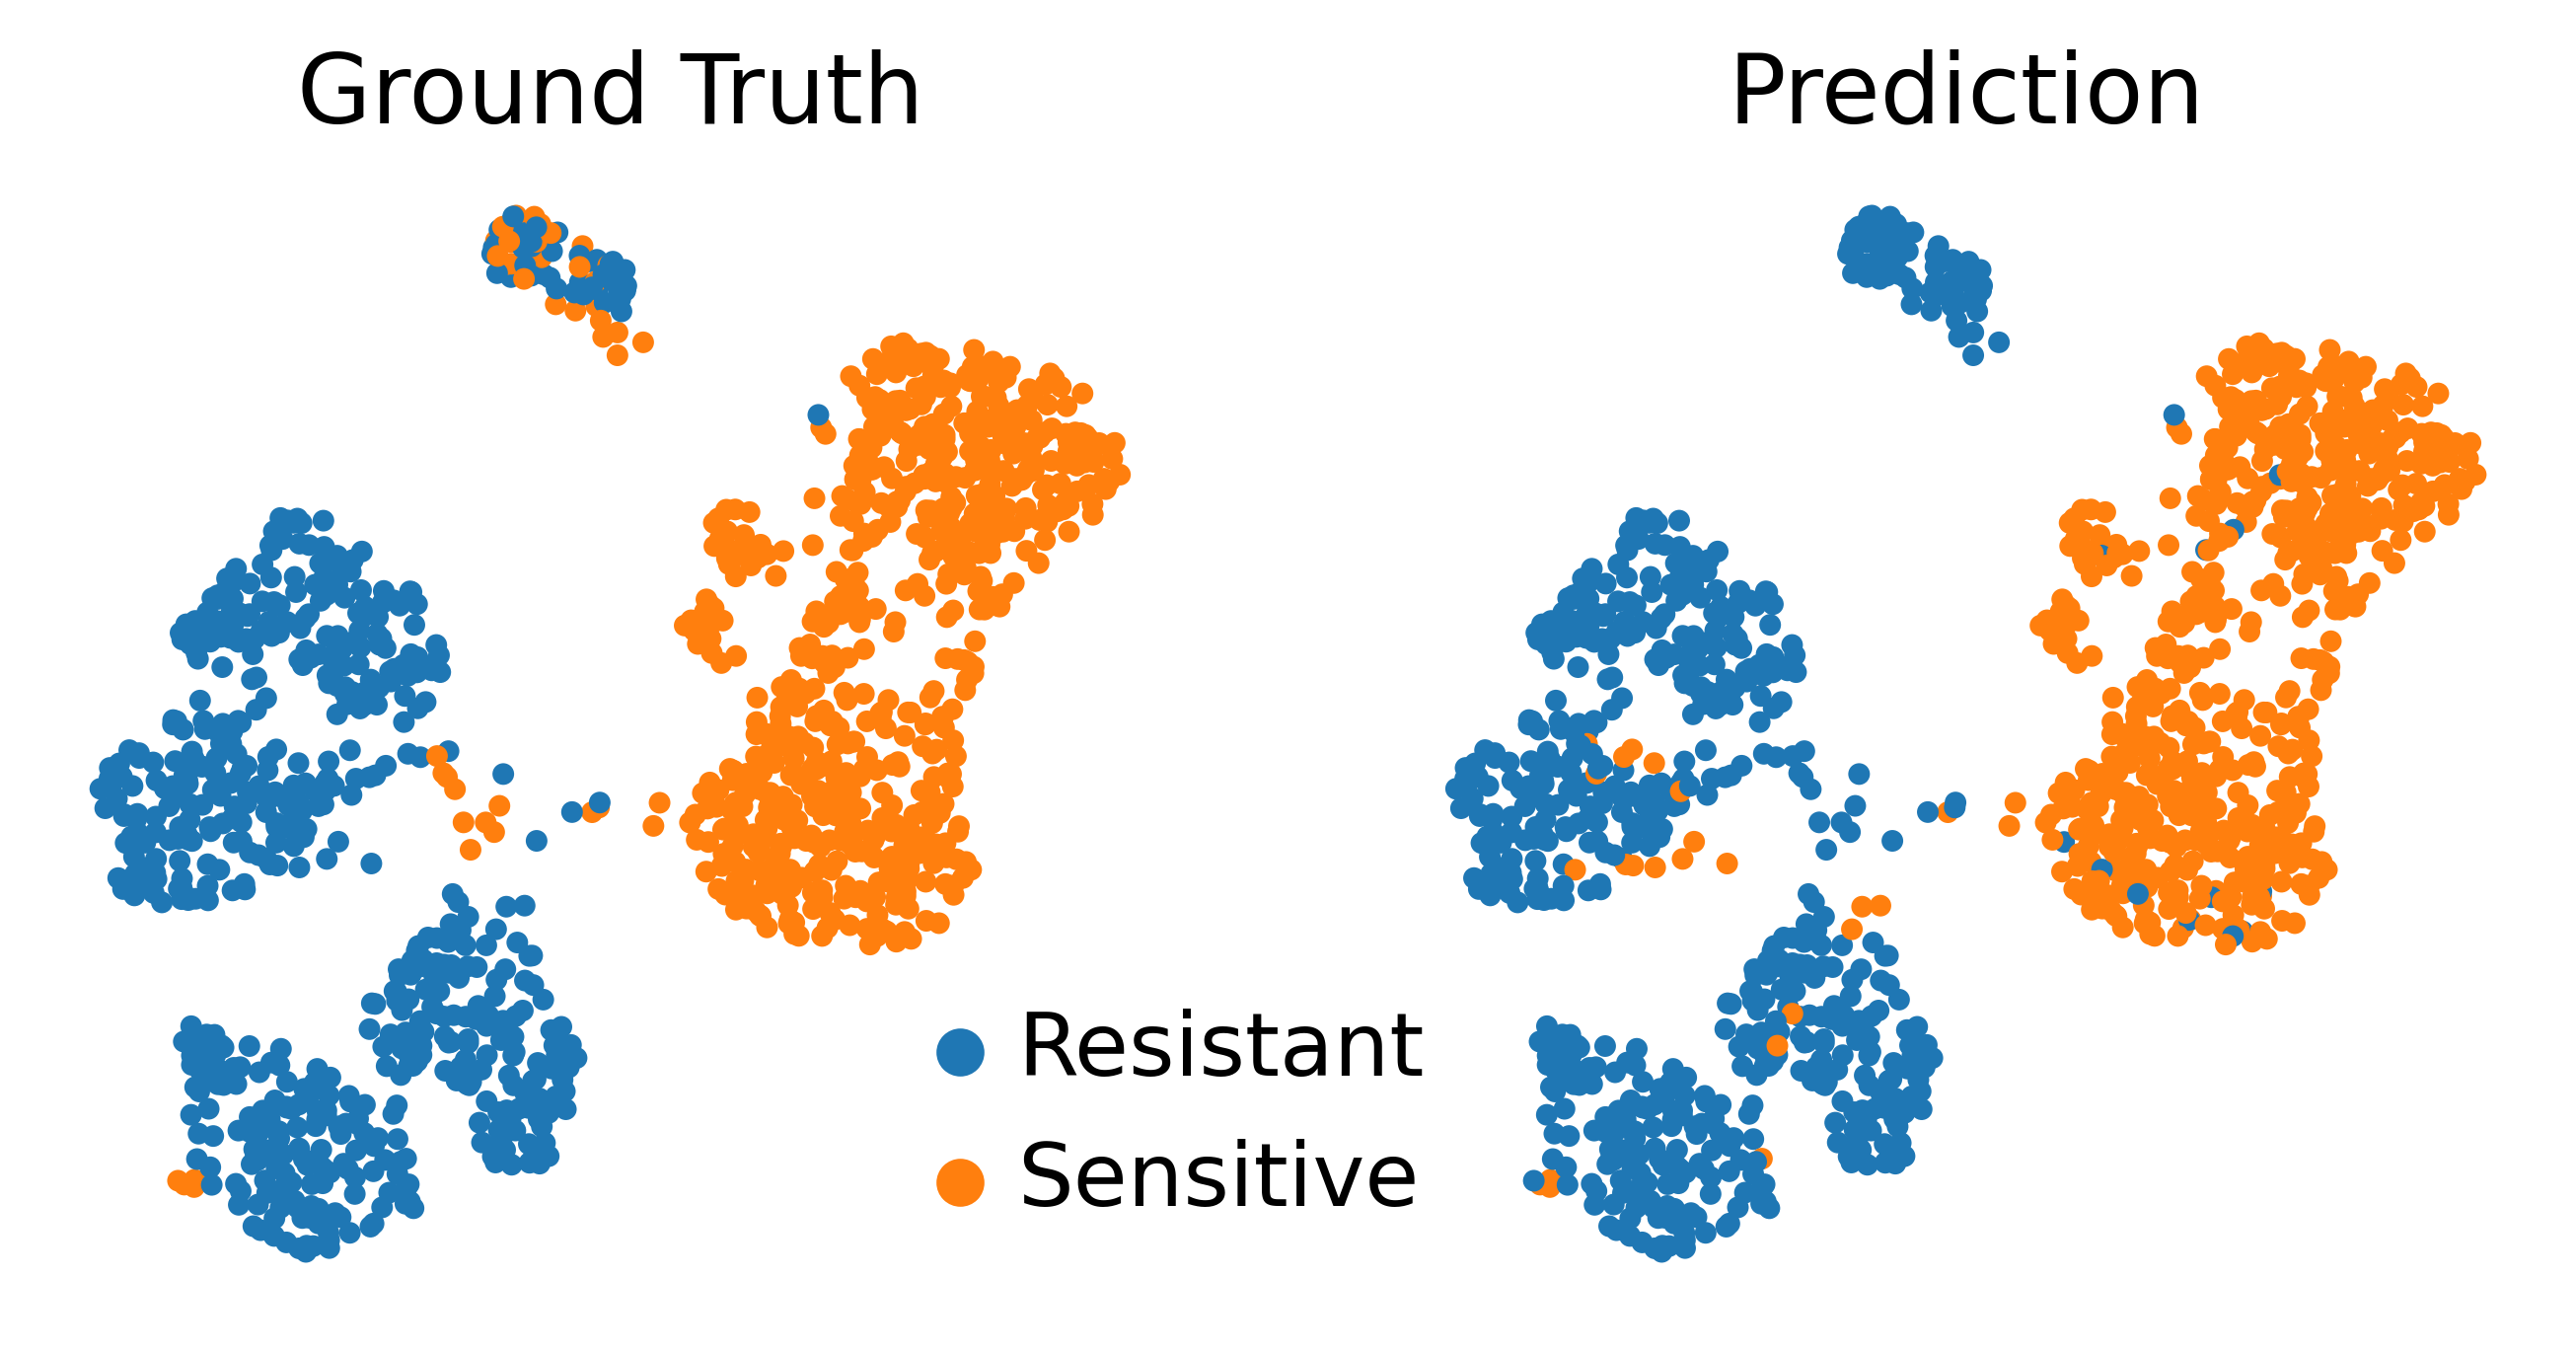

In [90]:
sc.settings.set_figure_params(dpi=250, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures
ax = sc.pl.umap(adata,color=['Ground Truth',"Prediction"],size=40,show=False,wspace=0.1)
ax[0].legend().remove()
ax[1].legend(loc ='lower center',bbox_to_anchor=(-0.2, 0),frameon=False) 
plt.savefig("saved/figures/figure2A_1"+name + ".tiff")

In [86]:
adata.obs

Plate# Well position                           Sample name  \
RPI1_A3    RPI1            A3              MA9 IBET RESISTANT CELLS   
RPI1_A4    RPI1            A4              MA9 IBET RESISTANT CELLS   
RPI1_A5    RPI1            A5              MA9 IBET RESISTANT CELLS   
RPI1_A6    RPI1            A6              MA9 IBET RESISTANT CELLS   
RPI1_A7    RPI1            A7              MA9 IBET RESISTANT CELLS   
...         ...           ...                                   ...   
RPI7_P18   RPI7           P18  MA9 IBET RESISTANT CELLS- WITHDRAWAL   
RPI7_P19   RPI7           P19  MA9 IBET RESISTANT CELLS- WITHDRAWAL   
RPI7_P20   RPI7           P20  MA9 IBET RESISTANT CELLS- WITHDRAWAL   
RPI7_P21   RPI7           P21                                 EMPTY   
RPI7_P22   RPI7           P22  MA9 IBET RESISTANT CELLS- WITHDRAWAL   

         Index-Sort condition Well index  sensitive Ground Truth  \
RPI1_A3                   GR+   GGTCTATG          0    Resistant   
RPI1_A4                   GR+   GTCCGAAT          0    Resistant   
RPI1_A5                   GR+   TAGTGCGT          0    Resistant   
RPI1_A6                   GR+   GACTGTAC          0    Resistant   
RPI1_A7                   GR+   TCCAGTAG          0    Resistant   
...                       ...        ...        ...          ...   
RPI7_P18                  GR-   ACGTGTGT          0    Resistant   
RPI7_P19                  GR-   TCAGCGTA          0    Resistant   
RPI7_P20                  GR-   AGAAGAGG          0    Resistant   
RPI7_P21                EMPTY   TATCCGGA          1    Sensitive   
RPI7_P22                  GR-   ACGACTCA          0    Resistant   

          Sensitive_score  Resistant_score  n_genes  ...  leiden_origin  \
RPI1_A3         -2.726364        14.205806     7132  ...              3   
RPI1_A4         -2.200808        10.421613     6815  ...              3   
RPI1_A5         -1.273636         5.788548     4951  ...              3   
RPI1_A6         -3.492323        16.025484     7615  ...              3   
RPI1_A7         -2.236667        13.070161     6688  ...              3   
...                   ...              ...      ...  ...            ...   
RPI7_P18        -1.348788         8.079032     5421  ...              1   
RPI7_P19        -1.234040         8.462097     5293  ...              1   
RPI7_P20        -0.823939         5.184032     4101  ...              1   
RPI7_P21        -0.295859         1.591129     2012  ...              1   
RPI7_P22        -1.377778         6.890806     5611  ...              1   

          sens_preds_pret  sens_label_pret    sens_preds  Prediction  \
RPI1_A3      9.923427e-01                1  1.397279e-05   Resistant   
RPI1_A4      9.971783e-01                1  6.654421e-05   Resistant   
RPI1_A5      6.018502e-01                1  4.892002e-05   Resistant   
RPI1_A6      9.987150e-01                1  2.667201e-06   Resistant   
RPI1_A7      9.964218e-01                1  3.161454e-06   Resistant   
...                   ...              ...           ...         ...   
RPI7_P18     9.500861e-01                1  1.172768e-05   Resistant   
RPI7_P19     9.966694e-01                1  2.155902e-05   Resistant   
RPI7_P20     4.932529e-04                0  6.169039e-04   Resistant   
RPI7_P21     1.469400e-07                0  2.102897e-09   Resistant   
RPI7_P22     9.880357e-01                1  4.814032e-05   Resistant   

          rest_preds   0_score   1_score  wrong pred_binary  
RPI1_A3     0.999988  1.143511 -0.296770    NaN   Resistant  
RPI1_A4     0.999959  1.074588 -0.224047    NaN   Resistant  
RPI1_A5     0.999947  1.005895 -0.224819    NaN   Resistant  
RPI1_A6     0.999998  1.124208 -0.325594    NaN   Resistant  
RPI1_A7     0.999997  1.196995 -0.284701    NaN   Resistant  
...              ...       ...       ...    ...         ...  
RPI7_P18    0.999992  1.048785 -0.338371    NaN   Resistant  
RPI7_P19    0.999991  1.233922 -0.308275    NaN   Resistant  
RPI7_P20    0.9

In [87]:
try:
    adata.obs["Sample name"] = adata.obs["cell_color"]
except:
    adata.obs["Sample name"] = adata.obs["Ground Truth"]

# Show the prediction probablity of drug resistant

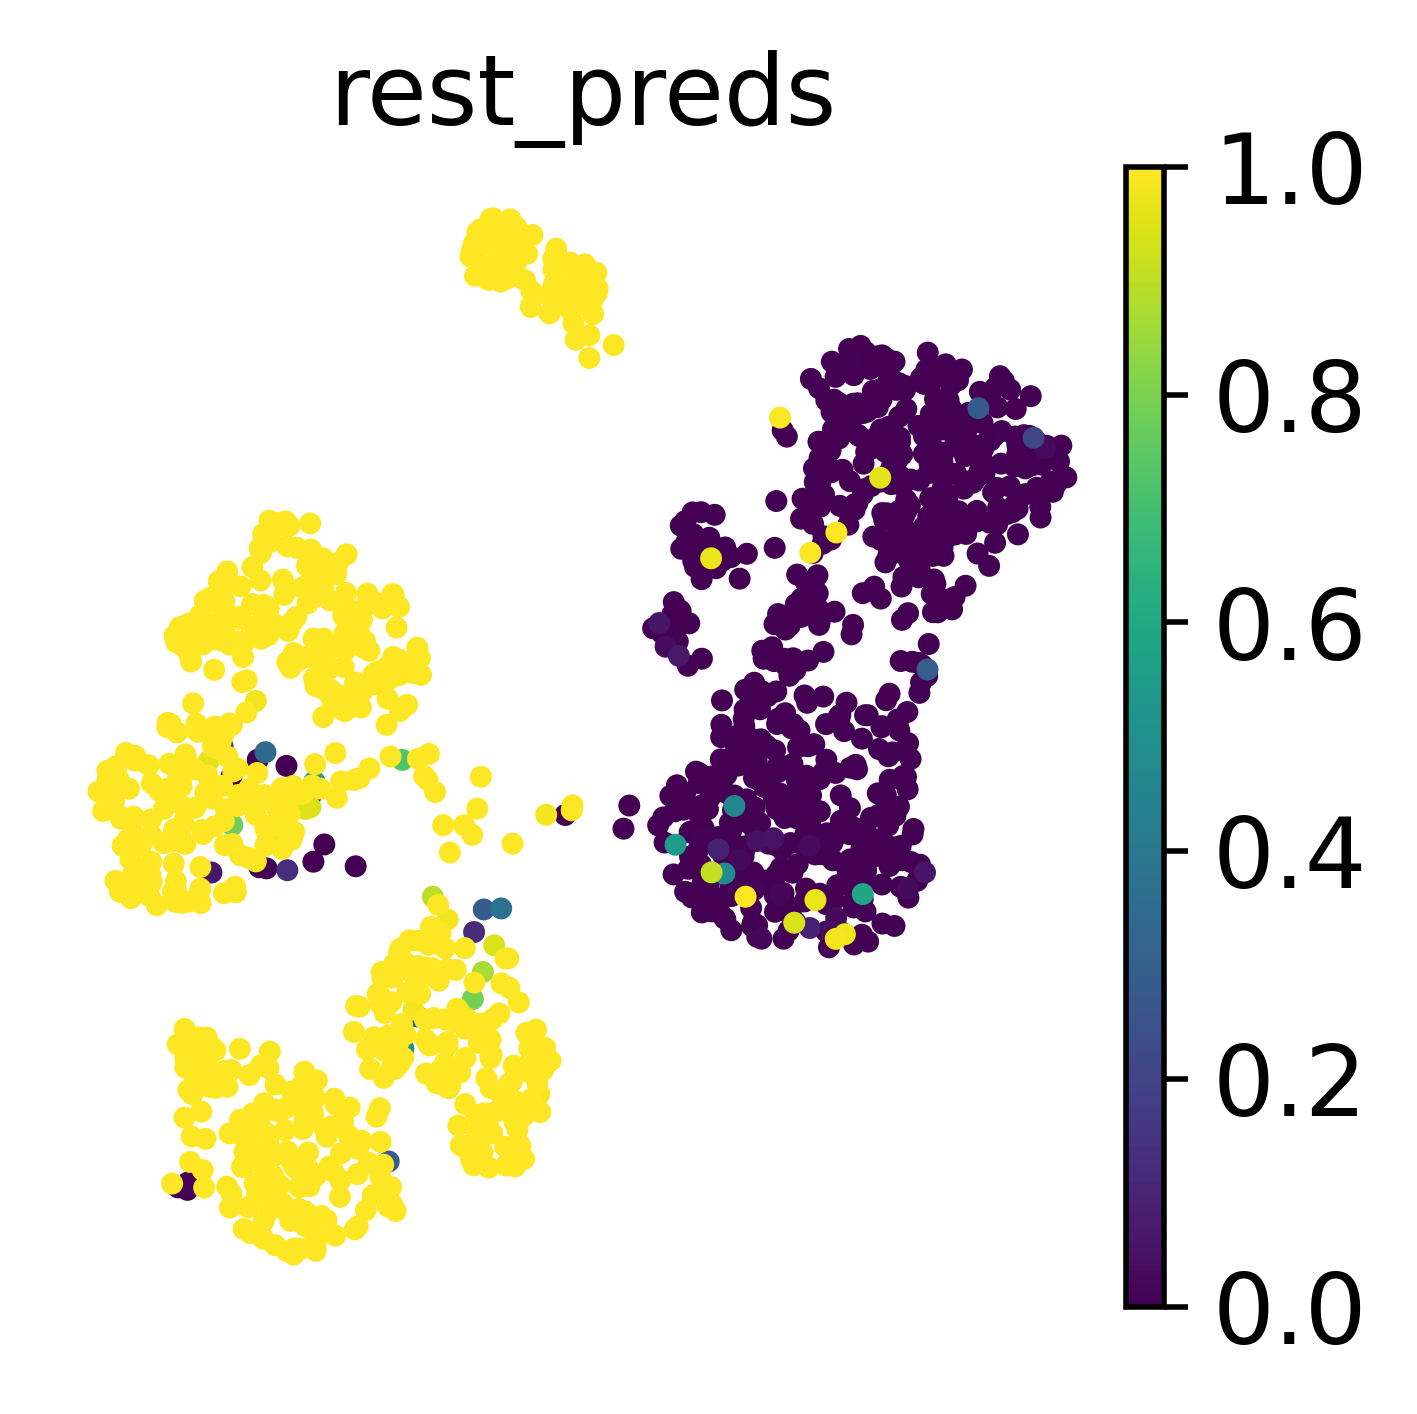

In [91]:
ax = sc.pl.umap(adata,color=["rest_preds"],size=40,palette="Paired",show=False)
plt.savefig("saved/figures/figure2A_2"+name + ".tiff")

In [92]:
adata.obs["Sample name"]

RPI1_A3     Resistant
RPI1_A4     Resistant
RPI1_A5     Resistant
RPI1_A6     Resistant
RPI1_A7     Resistant
              ...    
RPI7_P18    Resistant
RPI7_P19    Resistant
RPI7_P20    Resistant
RPI7_P21    Sensitive
RPI7_P22    Resistant
Name: Sample name, Length: 1419, dtype: category
Categories (2, object): ['Resistant', 'Sensitive']

# Show the cell type of the selected dataset

In [93]:
# ax = sc.pl.umap(adata,color=["Sample name"],size=40,palette="Paired",show=False)
# # ax.legend(loc ='lower center',bbox_to_anchor=(0.5, -0.55),frameon=False) 
# plt.savefig("saved/figures/figure2A_3"+name + ".tiff")

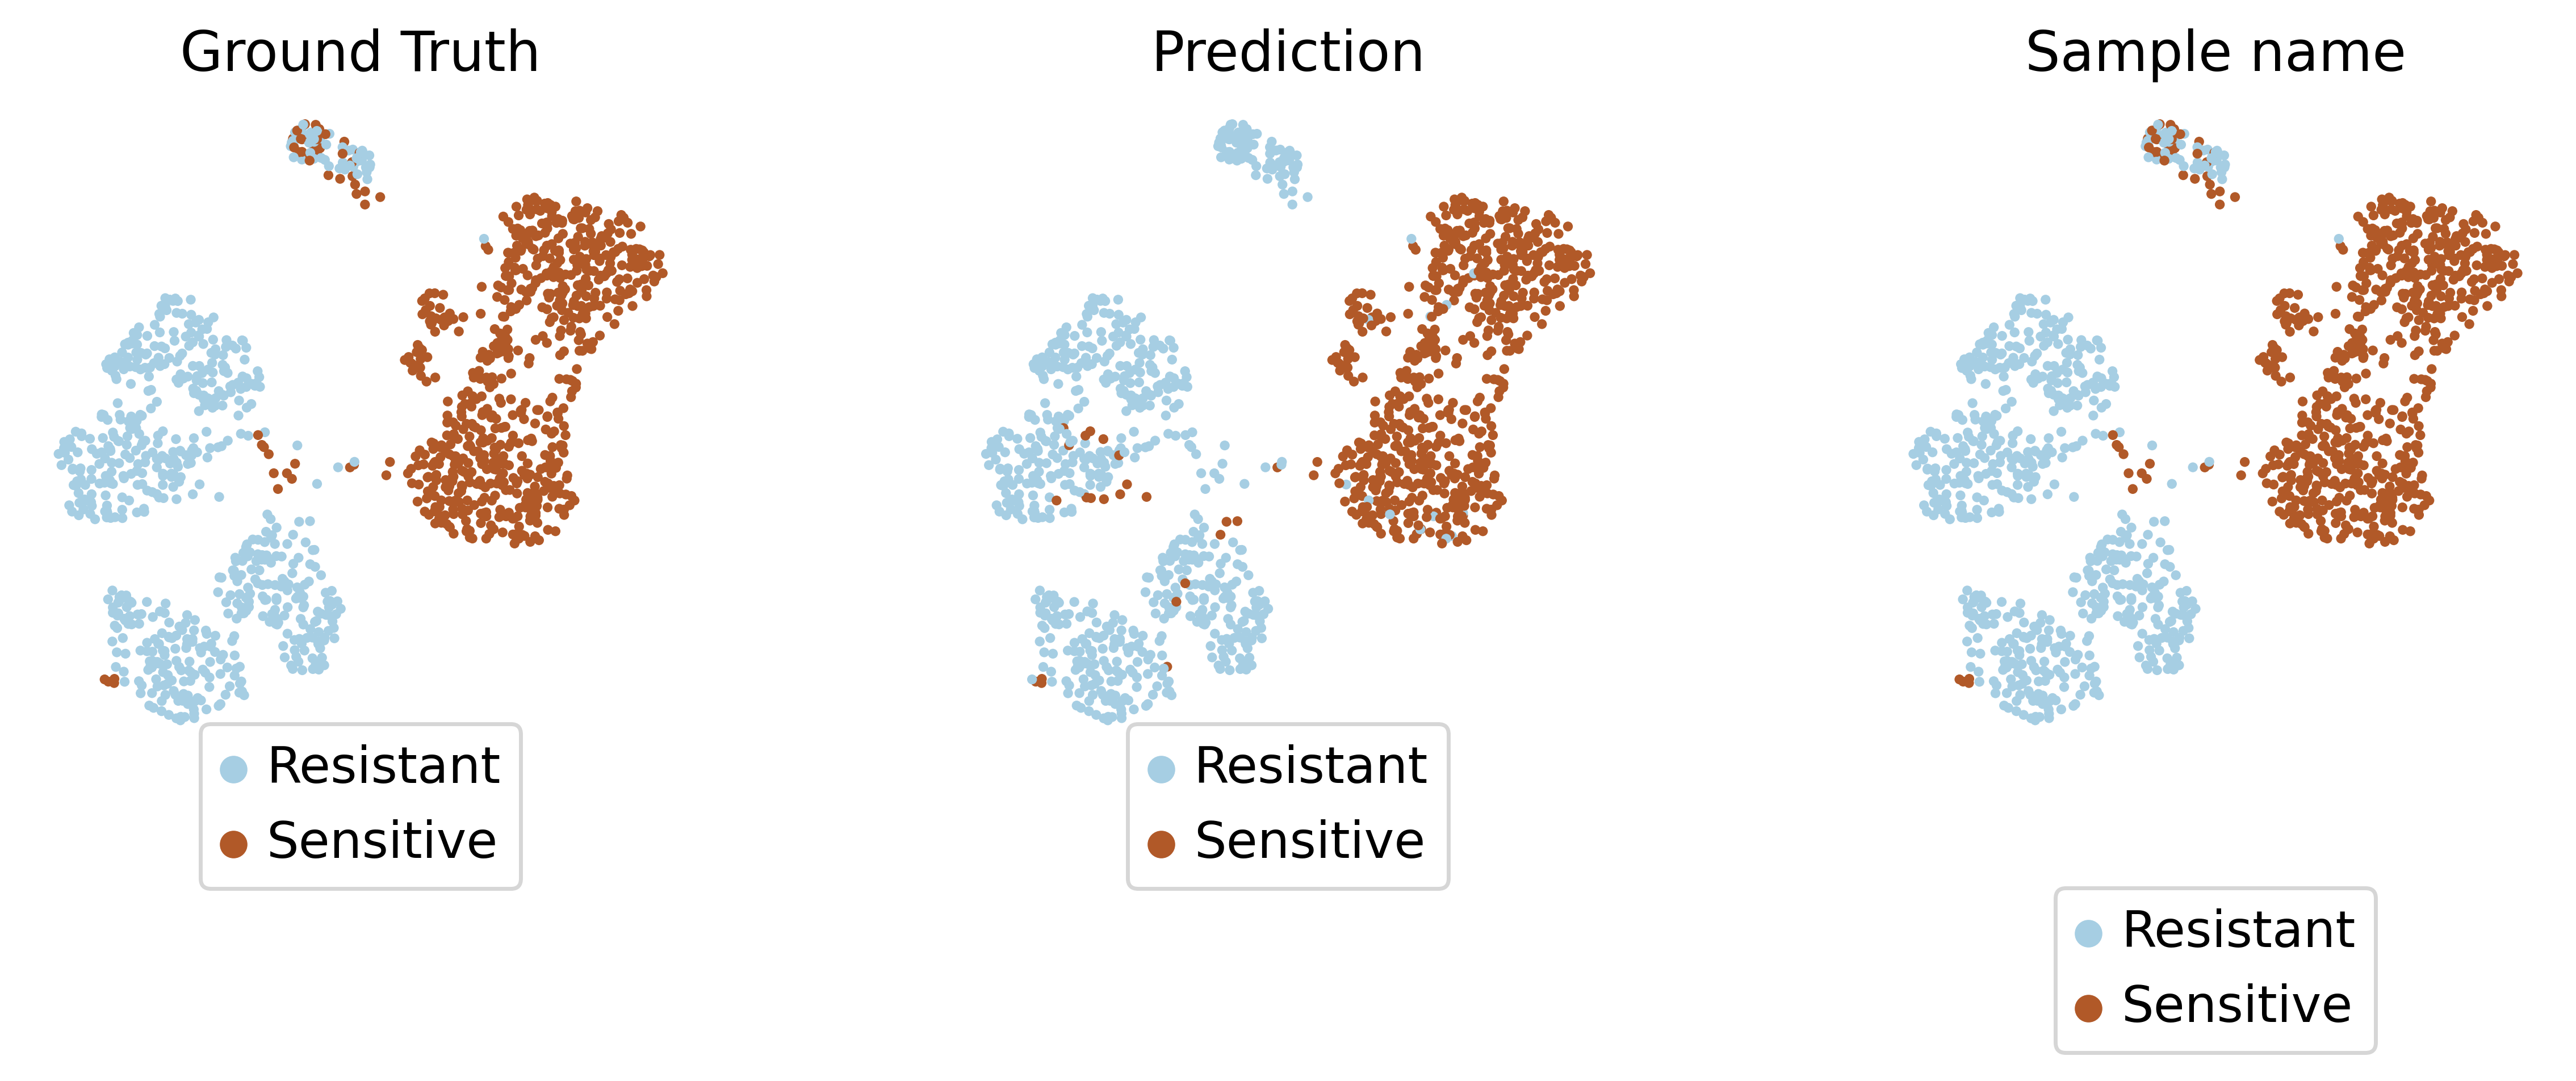

In [94]:
ax = sc.pl.umap(adata,color=['Ground Truth',"Prediction","Sample name"],size=25,palette="Paired",show=False)
ax[0].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.25)) 
ax[1].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.25)) 
ax[2].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.5)) 
#plt.savefig("figure2A_compare"+name + ".tiff")
plt.show()
plt.close()

# Show the gene module score of the sensitive and resistant cell clusters

The sensitive/resistant gene module score is the averaged expression score of the differently express genes within the sensitive/resistant cell cluster

In [95]:
adata = ut.de_score(adata,clustername='pred_binary')

In [96]:
sens_score,s_pval = pearsonr(adata.obs["1_score"],adata.obs["Sensitive_score"])
resistant_score,r_pval = pearsonr(adata.obs["0_score"],adata.obs["Resistant_score"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


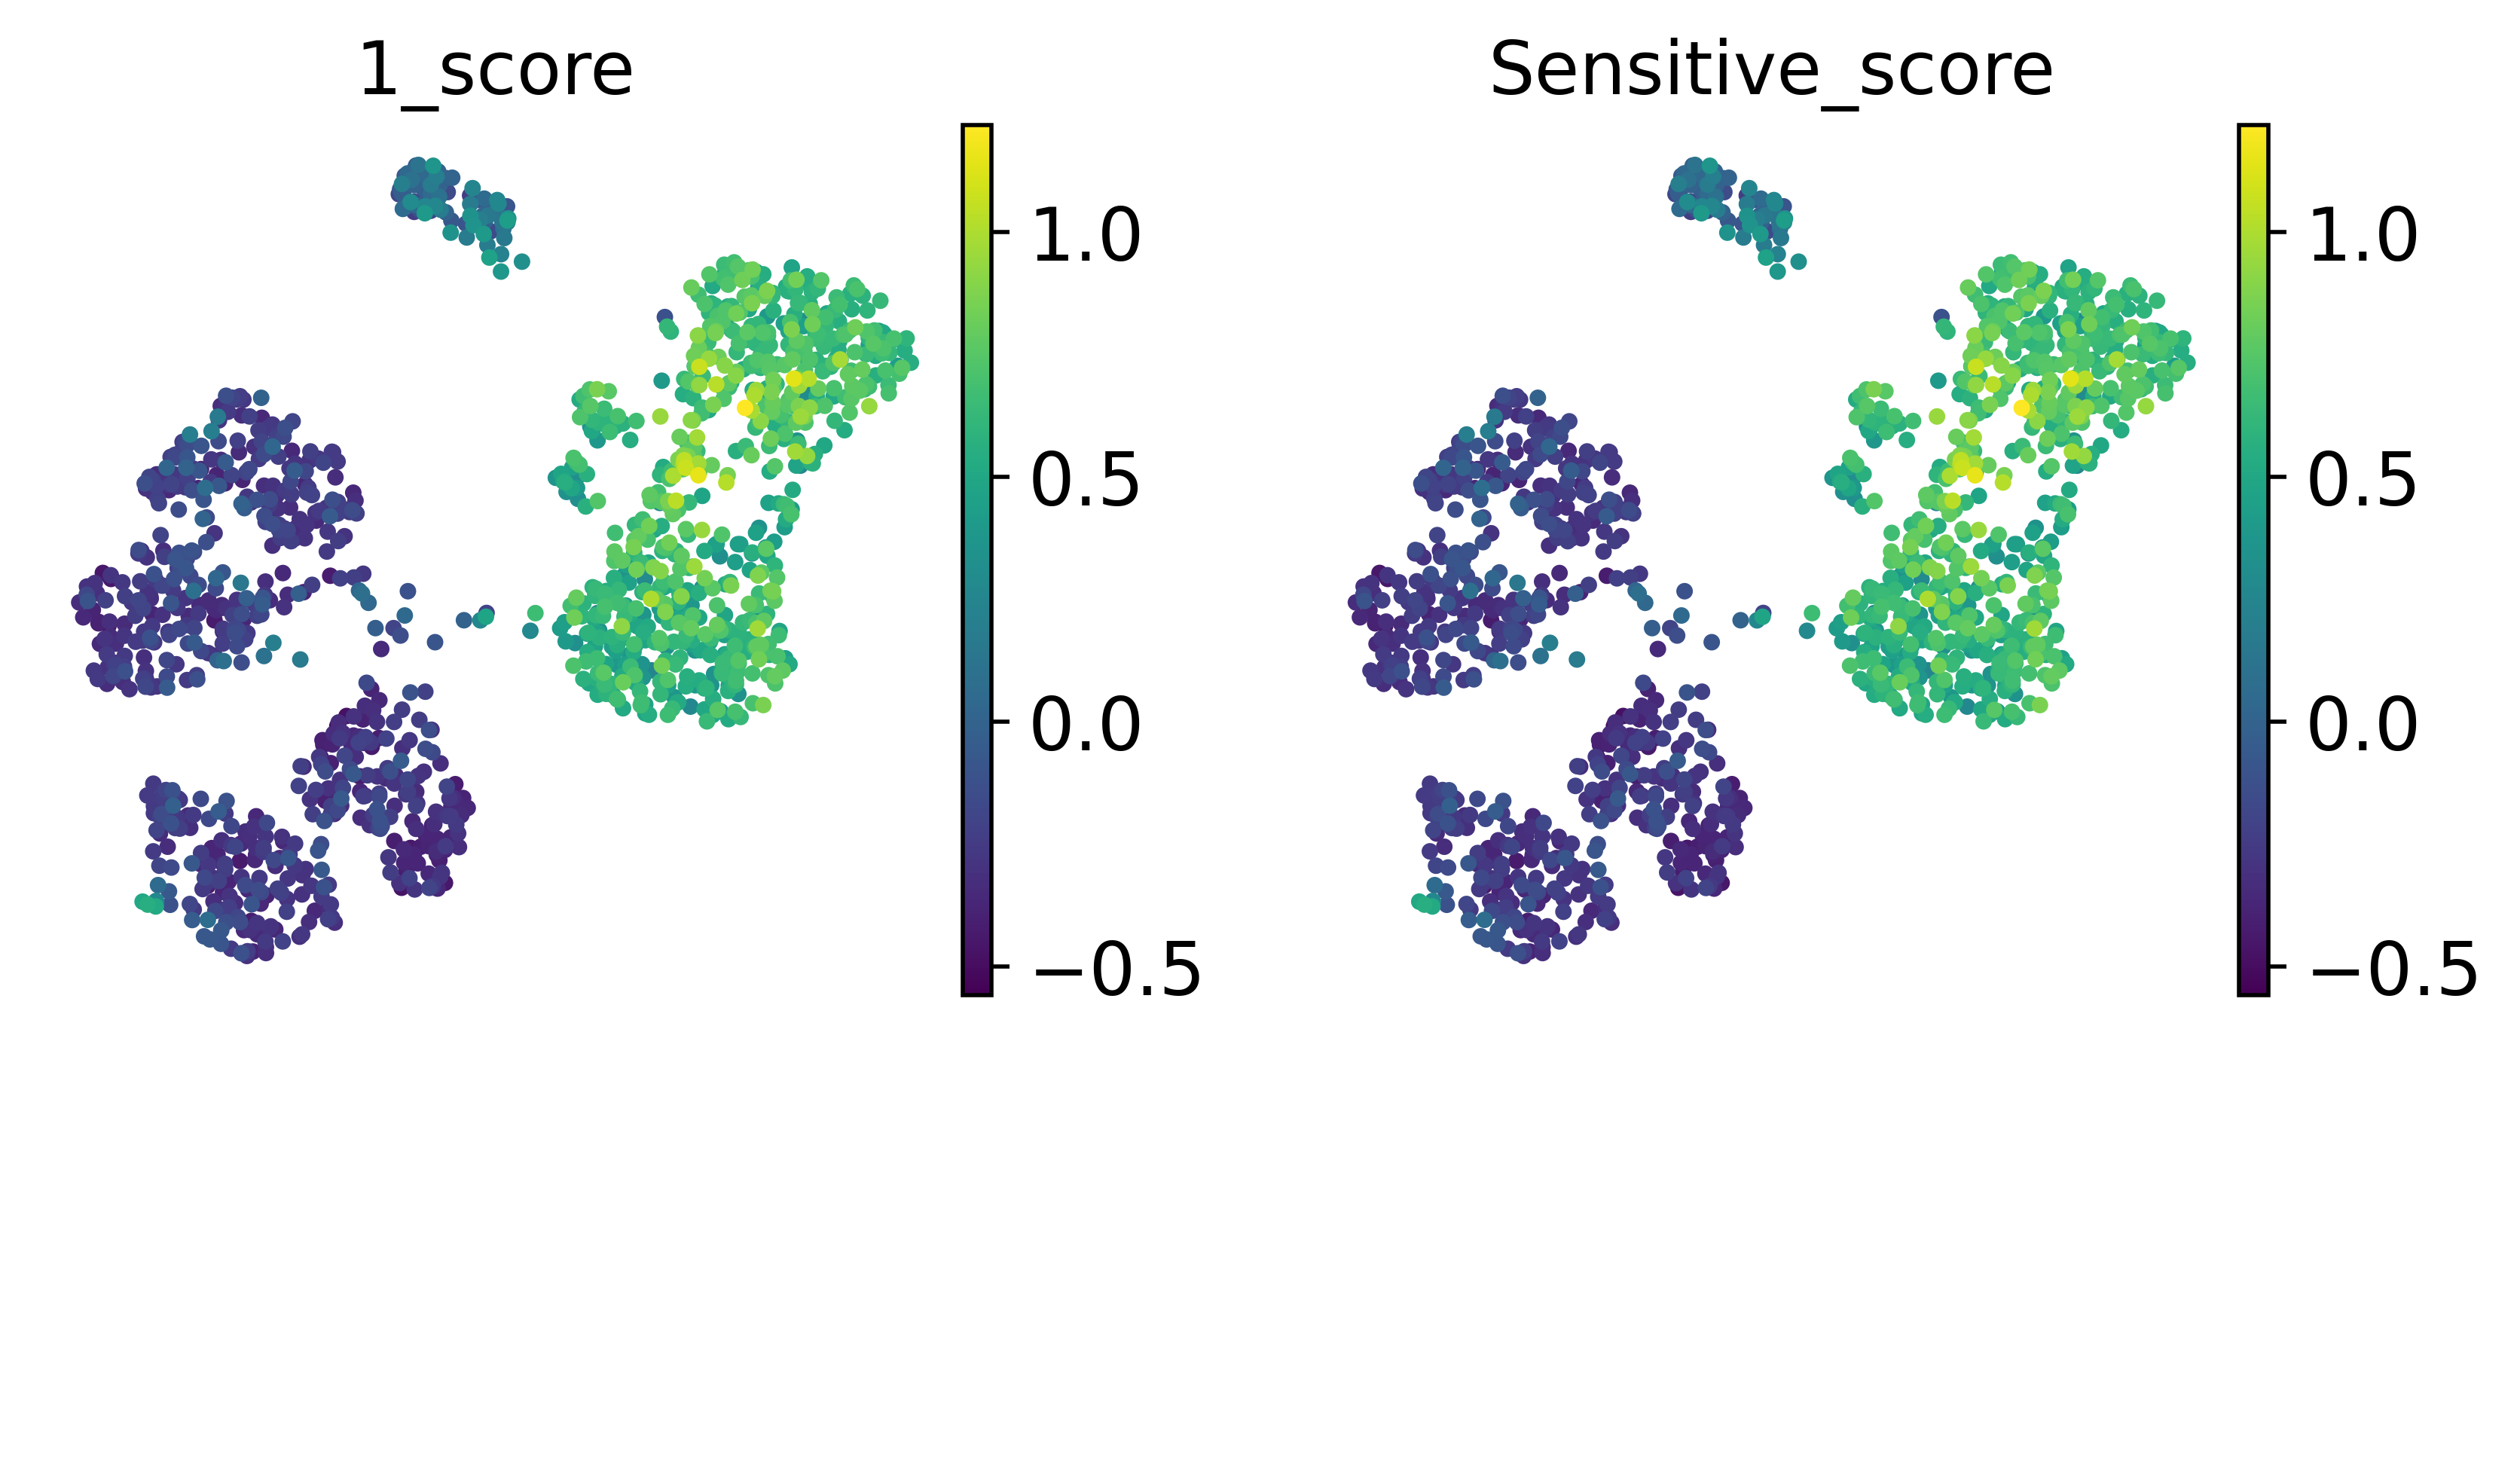

<Figure size 750x750 with 0 Axes>

In [97]:
ax = sc.pl.umap(adata,color=["1_score","Sensitive_score"],size=40,palette="Set2",show=False)
ax[0].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.55),frameon=False) 
ax[1].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.55),frameon=False) 
#plt.savefig("saved/figures/figure2A_4"+name + ".tiff")
plt.show()
plt.clf()

        Izquierda: intensidad del 1_score → qué tan sensibles parecen las células según su expresión génica.

        Derecha: Sensitive_score → predicción del modelo.

Comparando visualmente: Si los patrones se parecen, significa que la predicción está bien alineada con la biología subyacente.

1️⃣ Agrupa las células

Primero, se divide el conjunto de células en:

    Las que el modelo predice como sensibles

    Las que el modelo predice como resistentes

Esto es gracias a la columna pred_binary, que es el resultado del modelo (Sensitive vs Resistant).

2️⃣ Busca genes que distinguen a esos dos grupos

Luego, compara ambos grupos y se pregunta:

    “¿Qué genes están mucho más expresados en las células sensibles que en las resistentes, y viceversa?”

🔍 Resultado:

    Una lista de genes característicos de sensibilidad

    Otra lista de genes característicos de resistencia
3️⃣ Calcula un "parecido" a esos genes para cada célula

Para cada célula, calcula un score que representa:

    1_score: ¿cuánto se parecen los genes expresados en esta célula a los genes sensibles?

    0_score: lo mismo, pero con los genes resistentes.

👉 Es como decir:

    “Aunque esta célula esté en un clúster, ¿tiene la firma genética de una célula sensible o resistente?”

4️⃣ Lo graficas en UMAP

Ahí ves si las células predichas como sensibles realmente expresan más los genes sensibles → eso valida tu modelo.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


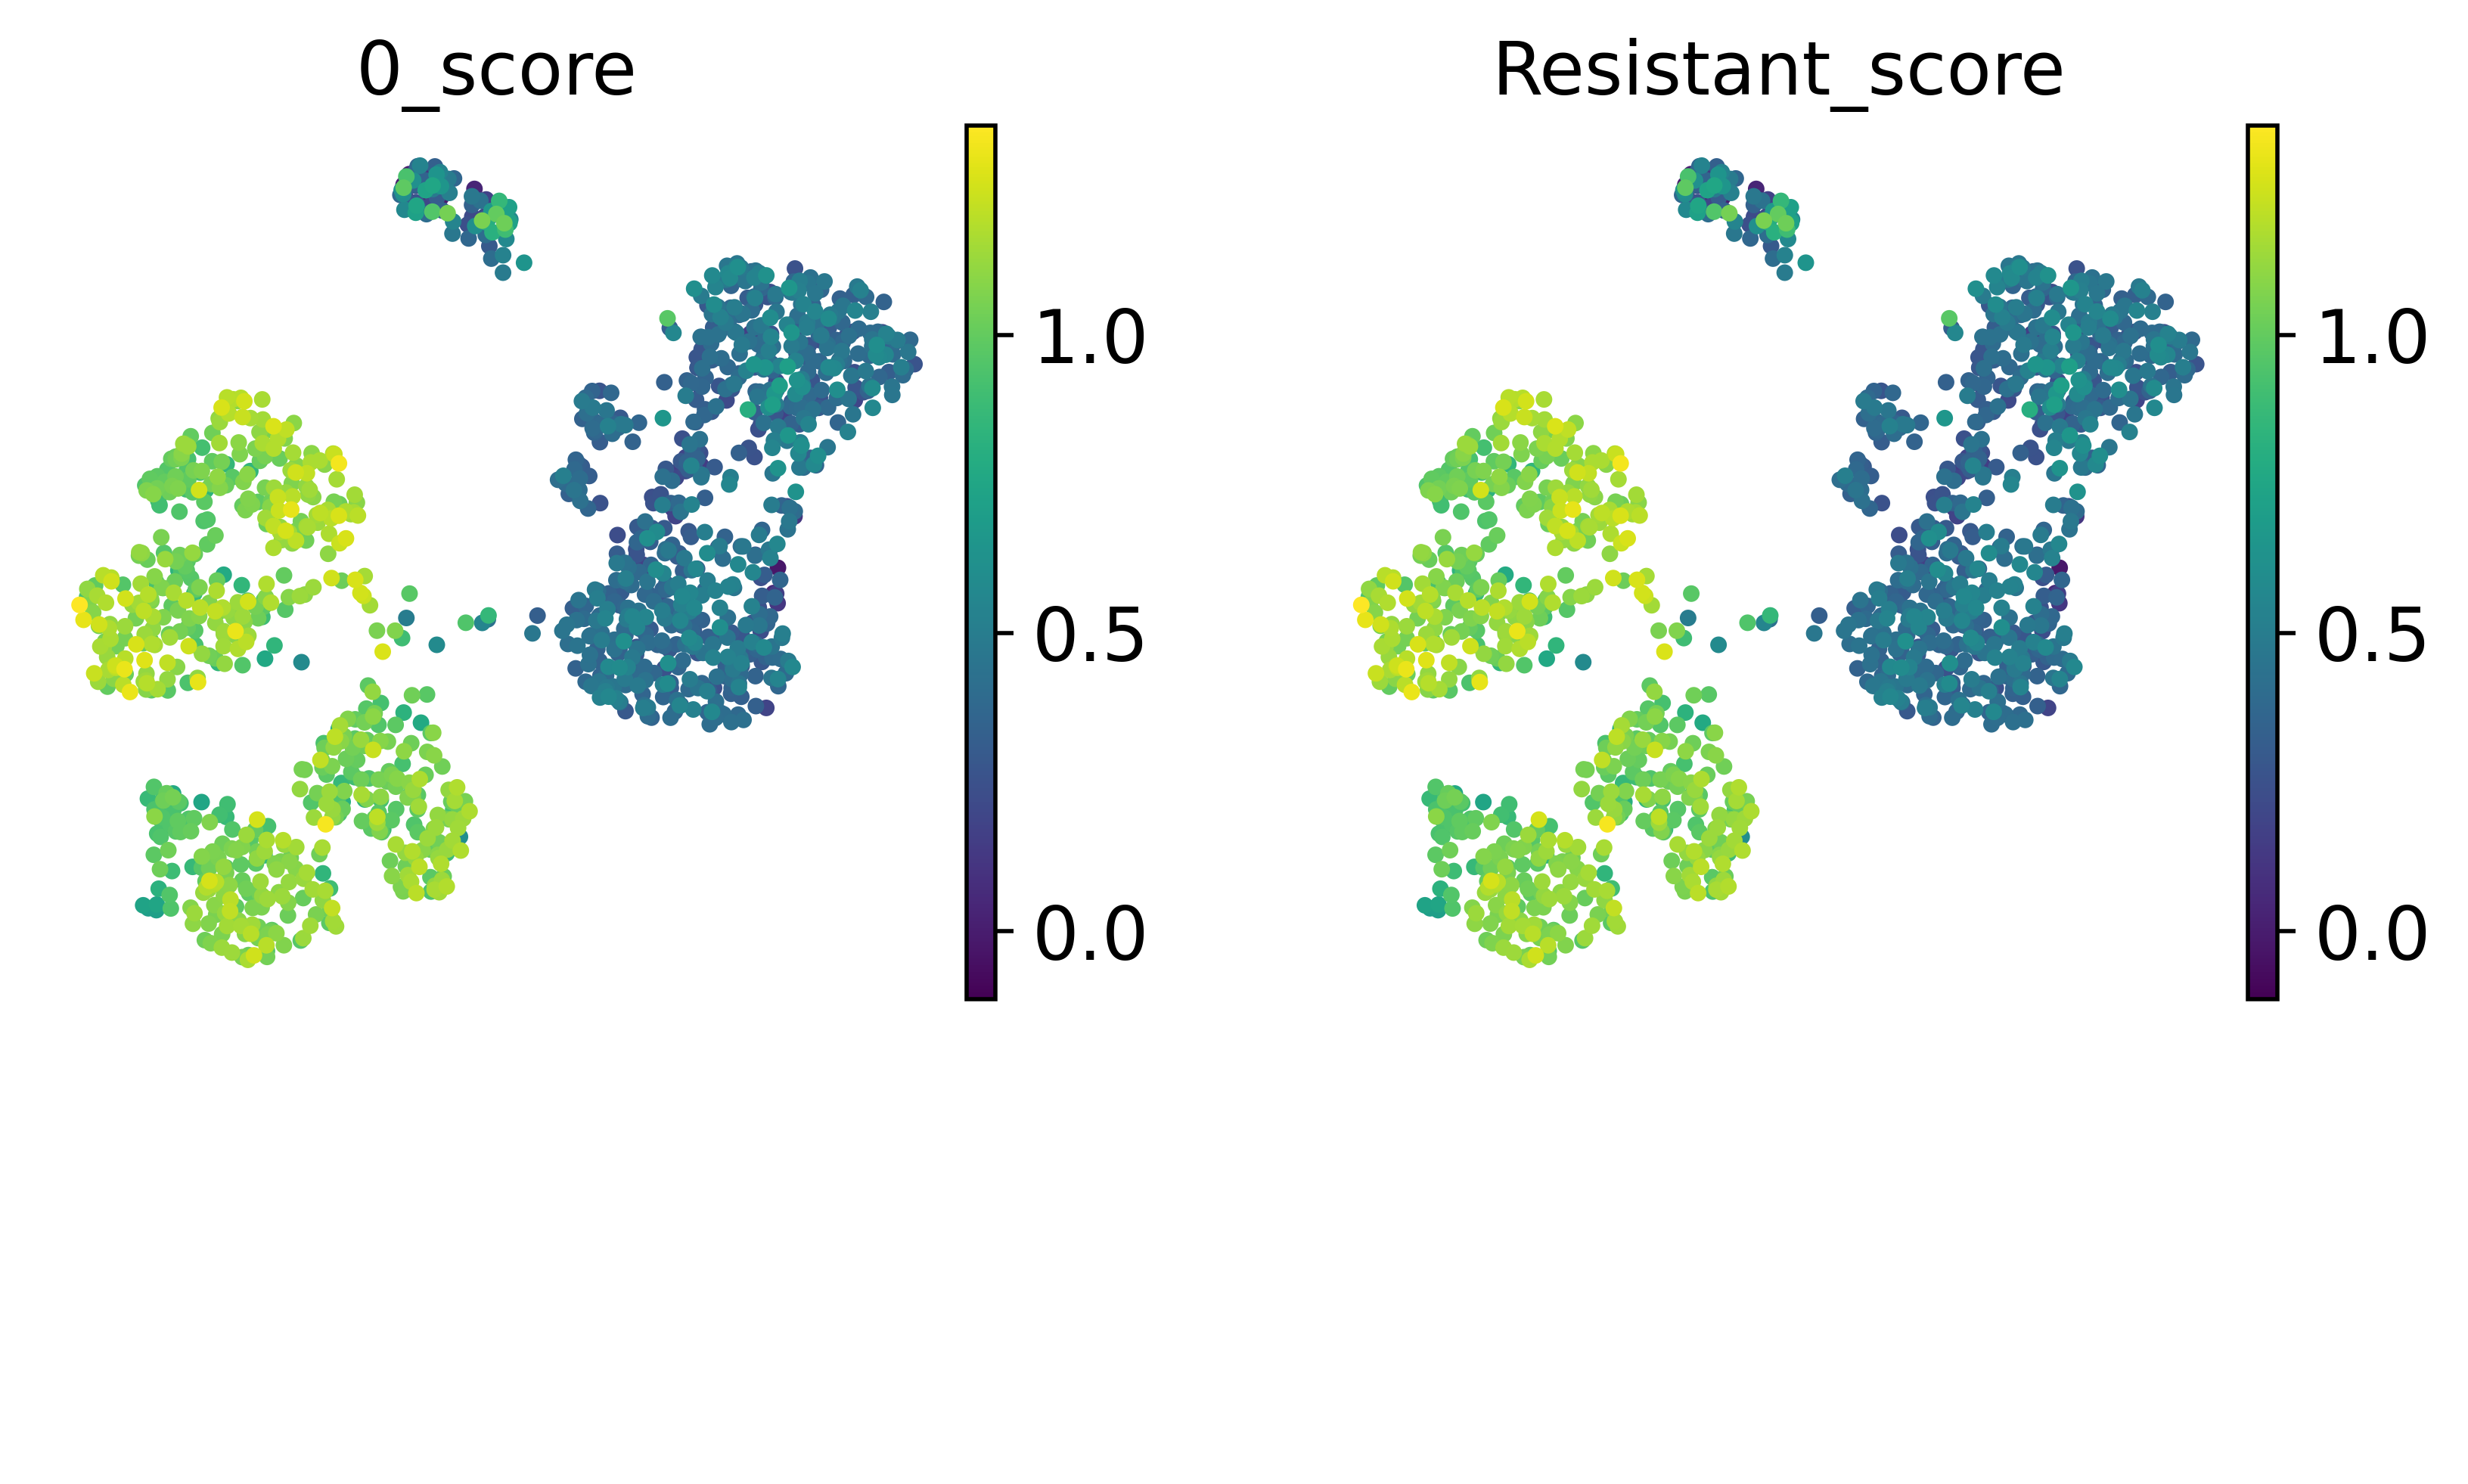

<Figure size 750x750 with 0 Axes>

In [101]:
ax = sc.pl.umap(adata,color=["0_score","Resistant_score"],size=40,palette="flare",show=False)
ax[0].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.55),frameon=False) 
ax[1].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.55),frameon=False) 
#plt.savefig("saved/figures/figure2A_5"+name + ".tiff")
plt.show()
plt.clf()

# pval of the gene module score

Imagina que tú tomas un grupo de genes que, según el análisis, parecen indicar si una célula es sensible o resistente al fármaco.

Pero te puedes preguntar:

    🧠 ¿Y si esos genes no son especiales? ¿Y si elegí genes al azar y también funciona?

In [102]:
def ran_test_score(adata,n_iters=1000):
    ran_results1 = []
    ran_results2 = []

    s_score,s_pval = pearsonr(adata.obs["1_score"],adata.obs["Sensitive_score"])
    r_score,r_pval = pearsonr(adata.obs["0_score"],adata.obs["Resistant_score"])


    for i in range(0,n_iters):

        gl1 = random.sample(list(adata.var.index),50)
        adata=sc.tl.score_genes(adata, gene_list=gl1,score_name="l1_score",copy=True)

        rand_score1,rand_pval1 = pearsonr(adata.obs["l1_score"],adata.obs["Sensitive_score"])
        rand_score2,rand_pval2 = pearsonr(adata.obs["l1_score"],adata.obs["Resistant_score"])

        ran_results1.append(rand_score1)
        ran_results2.append(rand_score2)
        
        
    return adata,ran_results1, s_score,s_pval ,ran_results2,r_score,r_pval

Está haciendo un experimento que se llama test aleatorio (randomization test) para ver si tus genes realmente funcionan mejor que genes al azar.

In [104]:
adata,s_ran, s_score,s_pval ,r_ran,r_score,r_pval = ran_test_score(adata,100)#aqui coge genes aleatorios

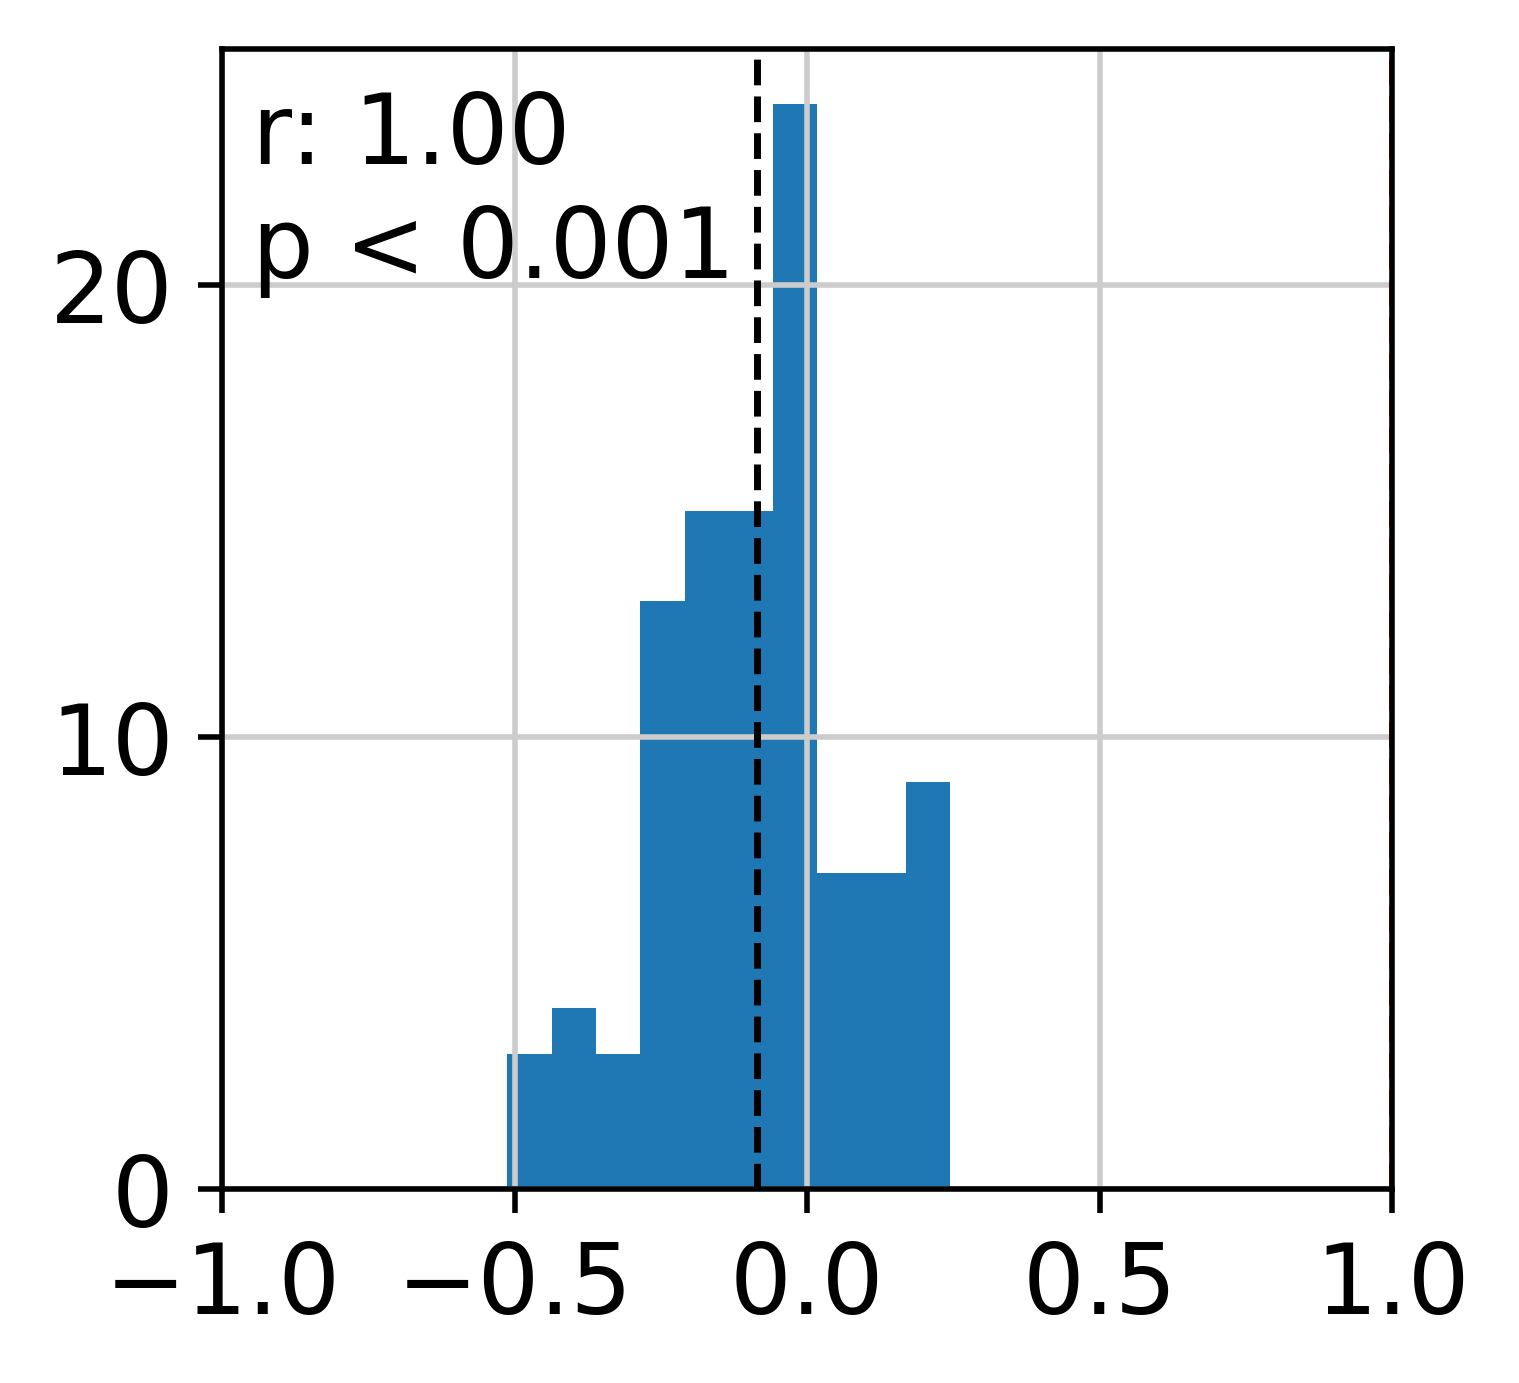

In [105]:
plt.hist(r_ran)
plt.xlim(xmin=-1, xmax = 1)
plt.axvline(r_score, color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(r_ran), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
#plt.text(-1, max_ylim*0.7, 'Mean: {:.2f}'.format(np.mean(r_ran)))
plt.text(-0.95, max_ylim*0.8, 'p < 0.001', color='k')
plt.text(-0.95, max_ylim*0.9, 'r: {:.2f}'.format(r_score), color='k')
plt.show()


Ningún conjunto aleatorio alcanzó una correlación tan alta.

Eso quiere decir que tus genes son significativamente mejores que el azar.

El p < 0.001 indica que la probabilidad de obtener una correlación igual o mayor por casualidad es menor del 0.1%.

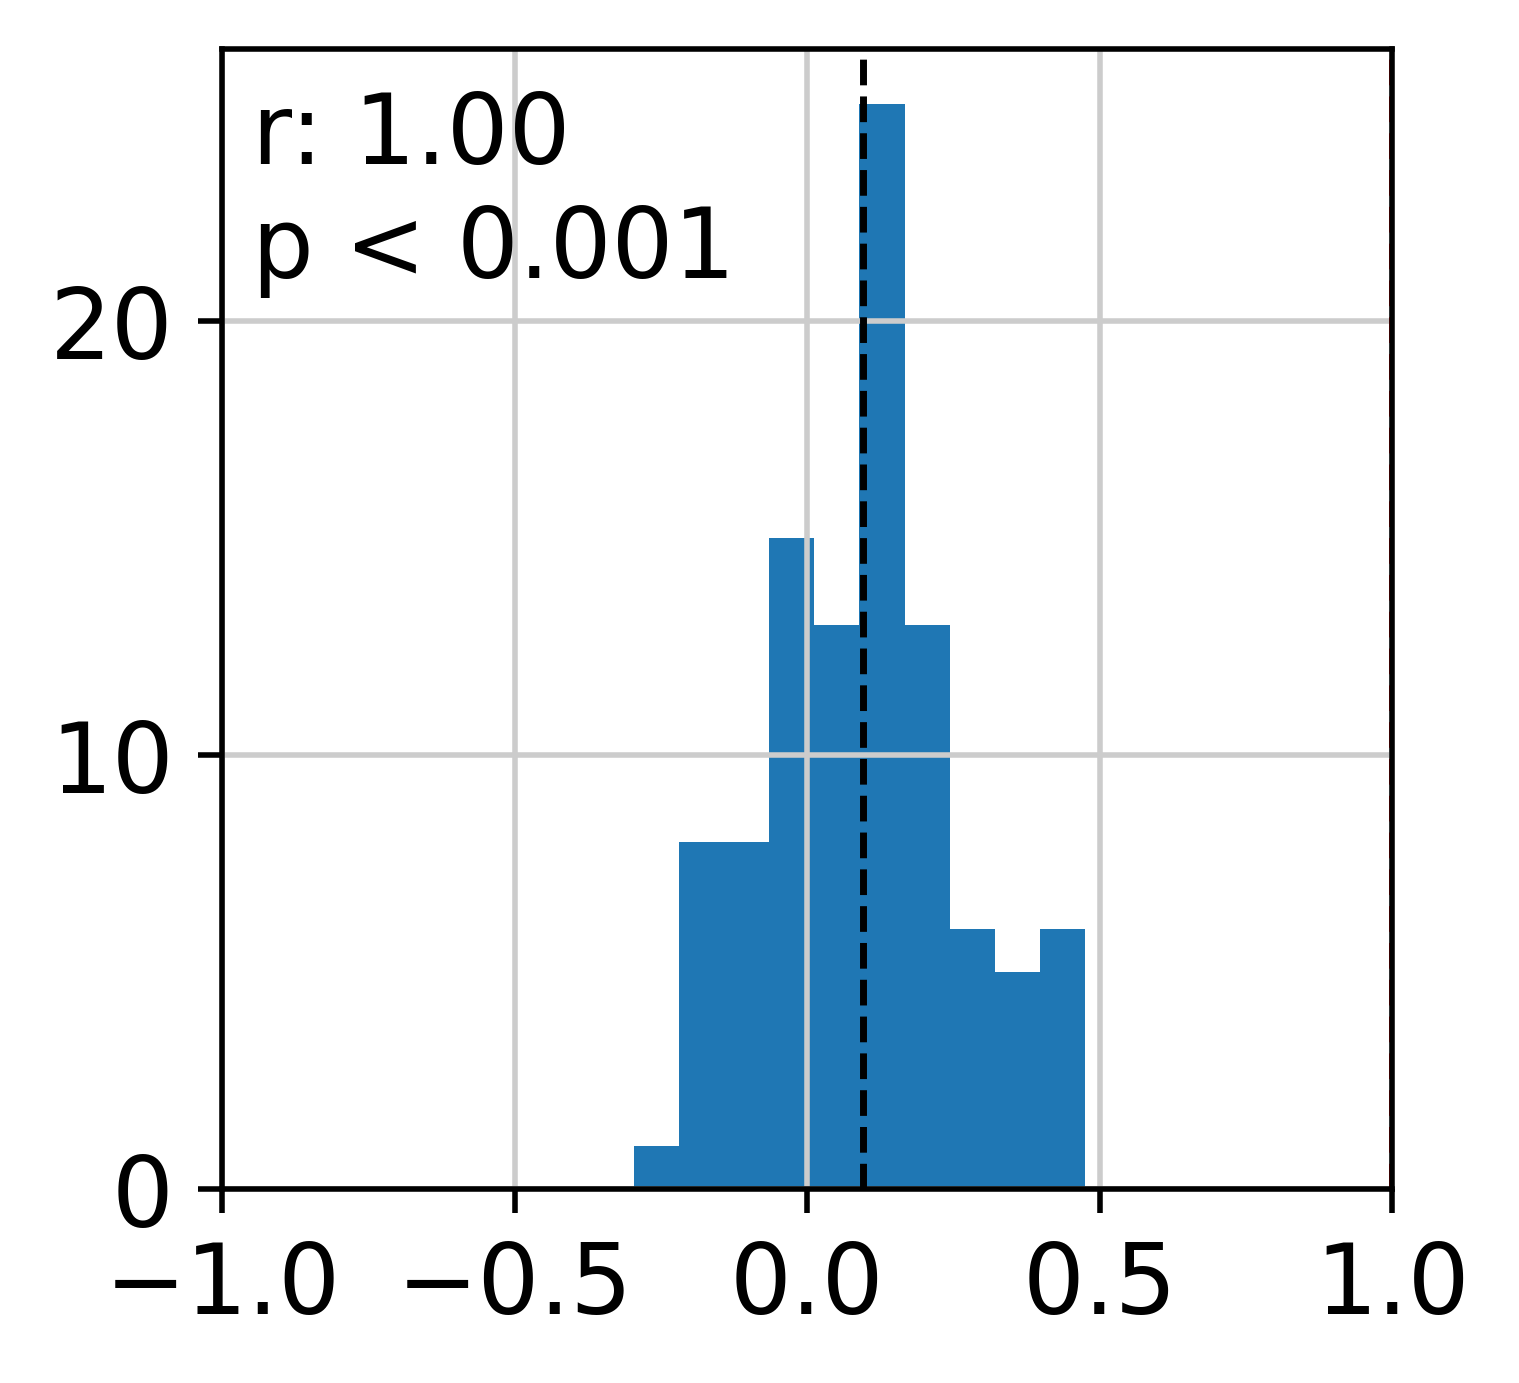

In [107]:
plt.hist(s_ran)
plt.xlim(xmin=-1, xmax = 1)
plt.axvline(s_score, color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(s_ran), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
#plt.text(-1, max_ylim*0.7, 'Mean: {:.2f}'.format(np.mean(r_ran)))
plt.text(-0.95, max_ylim*0.8, 'p < 0.001', color='k')
plt.text(-0.95, max_ylim*0.9, 'r: {:.2f}'.format(s_score), color='k')
plt.savefig("saved/figures/random_senstive_gene"+name + '.svg')
plt.show()

# Show the correlation between the gene score and the prediction cell type

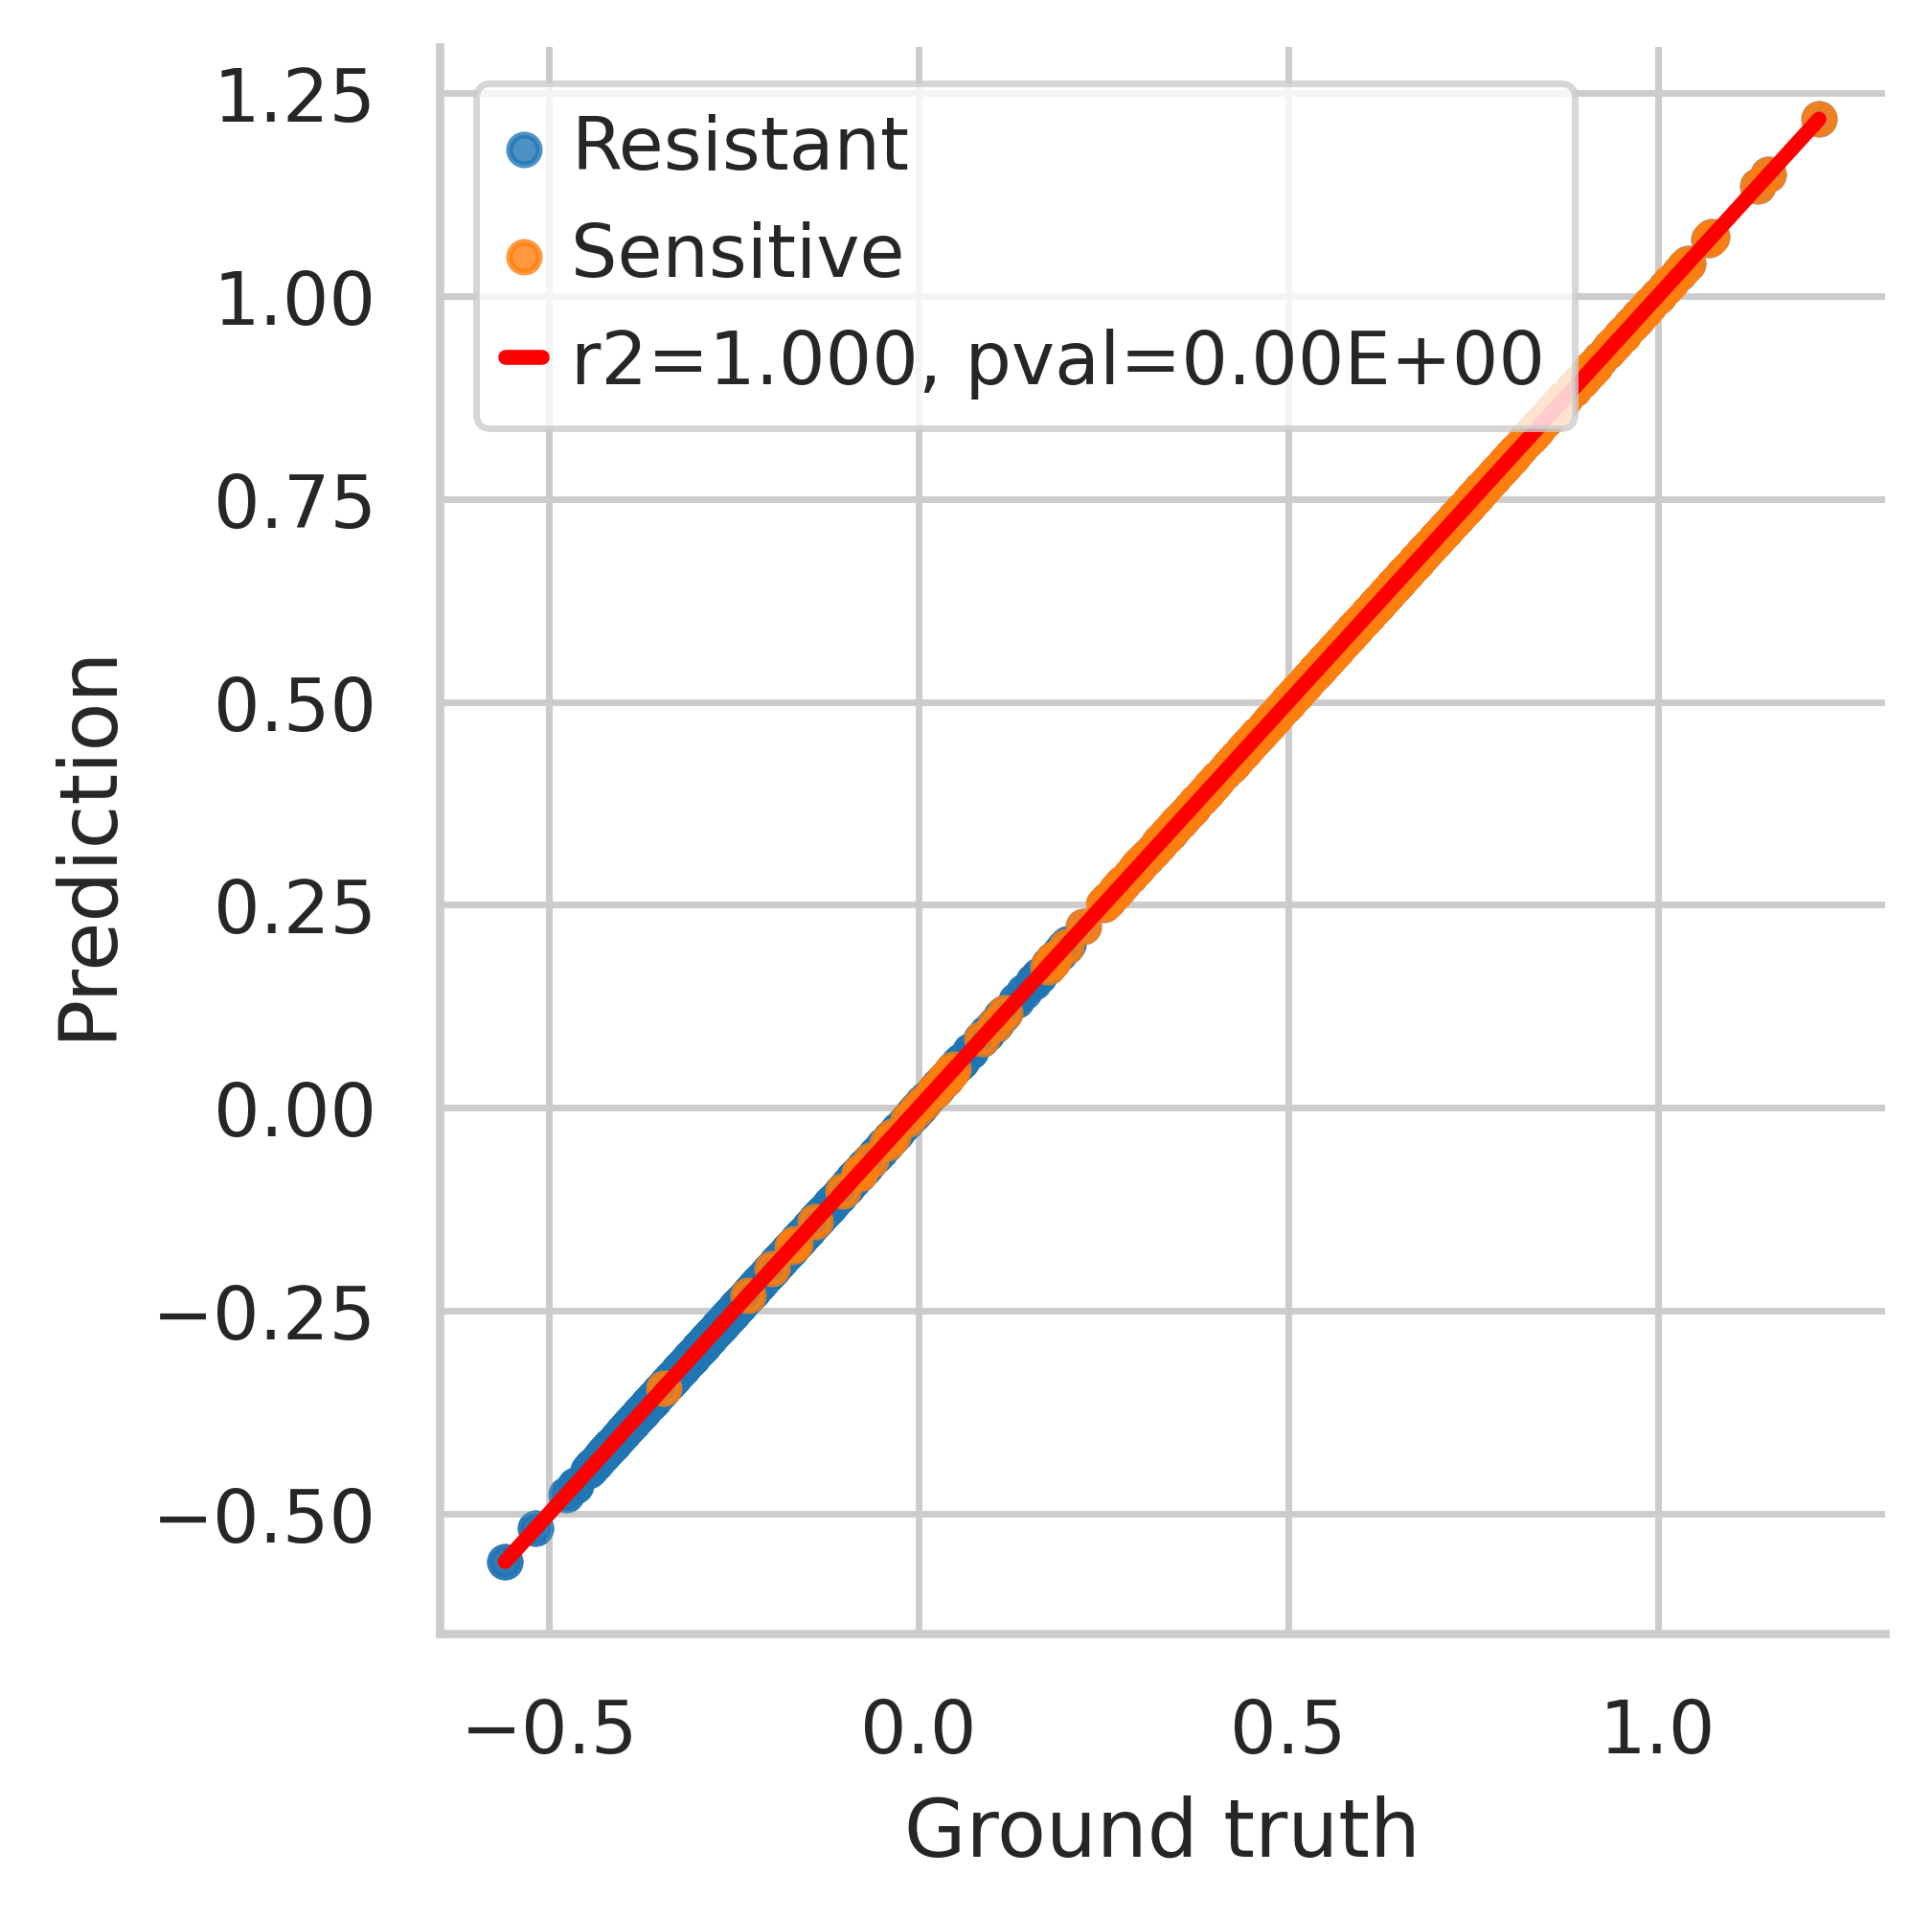

<Figure size 750x750 with 0 Axes>

In [111]:
import scipy as sp
from sklearn.preprocessing import MinMaxScaler

sns.set_theme(style="whitegrid")

score_1 = adata.obs.loc[:,'Sensitive_score'].ravel()
score_2 = adata.obs.loc[:,'1_score'].ravel()
c = adata.obs.loc[:,"Ground Truth"].values


scaler = MinMaxScaler()

DF_0 = pd.DataFrame({"Ground truth":score_1,"Prediction":score_2,"color":c})


r, p = sp.stats.pearsonr(score_1, score_2)

line_kws={'label':"r2={0:.3f}, pval={1:.2E}".format(r,p),"color":"red"}

sns.lmplot(x='Ground truth', y='Prediction', hue='color', data=DF_0, fit_reg=False, legend=False,scatter_kws={"s":20},\
           #palette=sns.color_palette("tab10_r",10)[8:10]
           palette=sns.color_palette("tab10",2)
)

ax = sns.regplot(x=score_1, y=score_2,logx=False, line_kws=line_kws, scatter_kws={"zorder":-1,"s":20})
ax.legend(loc='upper left')
ax.figure.set_size_inches(4, 4)

sns.despine(left=False)
plt.show()
#plt.savefig("saved/figures/Regplot_sesistive_"+name+".tiff")
plt.clf()


In [114]:
r, p = sp.stats.pearsonr(score_1, score_2)
print("r:", r, "p:", p) 
#muy raro

r: 1.0 p: 0.0


¿Qué puedes leer del gráfico?

    Si los puntos forman una línea clara hacia arriba → hay alta correlación: lo que el modelo predice coincide con la expresión real de los genes.

    Si hay mezcla o dispersión → baja correlación.

    El color te ayuda a ver si eso es diferente entre sensibles y resistentes.

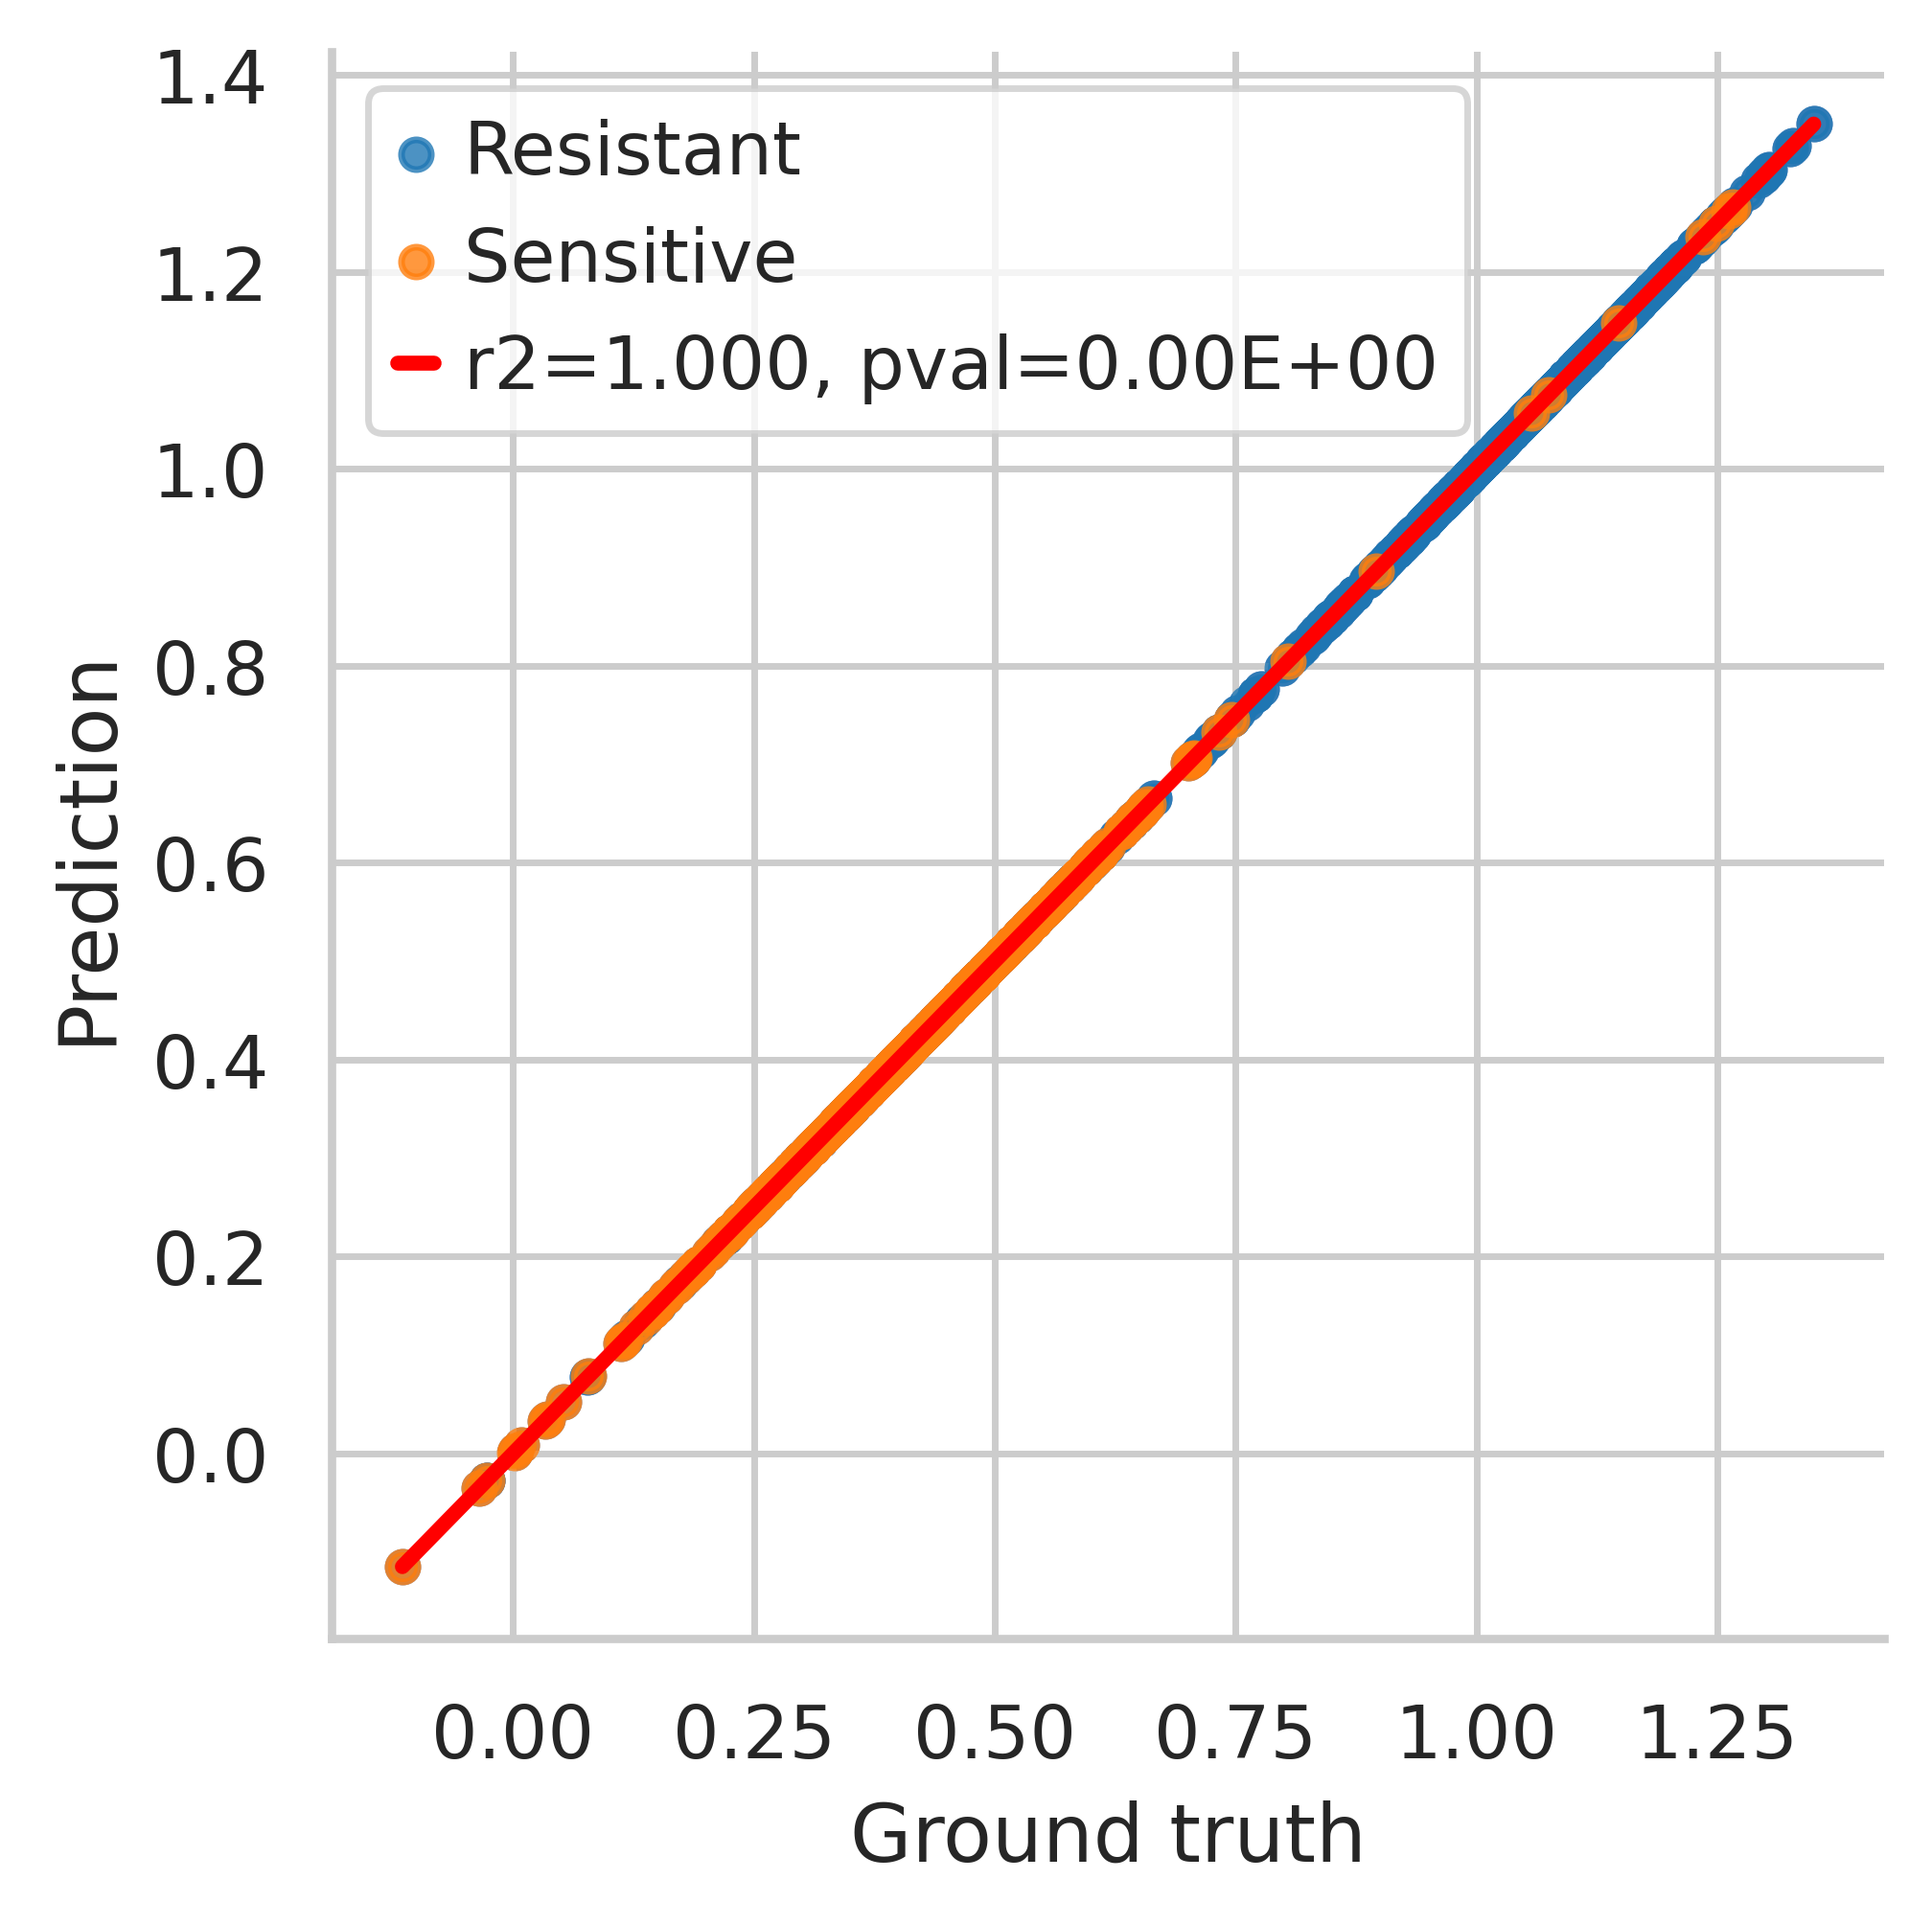

<Figure size 750x750 with 0 Axes>

In [112]:
score_1 = adata.obs.loc[:,'Resistant_score'].ravel()
score_2 = adata.obs.loc[:,'0_score'].ravel()
c = adata.obs.loc[:,"Ground Truth"].values

# score_1 = np.clip(score_1,np.percentile(score_1, 5),np.percentile(score_1, 95))
# score_2 = np.clip(score_2,np.percentile(score_2, 5),np.percentile(score_2, 95))

DF_0 = pd.DataFrame({"Ground truth":score_1,"Prediction":score_2,"color":c})


r, p = sp.stats.pearsonr(score_1, score_2)

line_kws={'label':"r2={0:.3f}, pval={1:.2E}".format(r,p),"color":"red"}

sns.lmplot(x='Ground truth', y='Prediction', hue='color', data=DF_0, fit_reg=False, legend=False,scatter_kws={"s":20},\
           #palette=sns.color_palette("tab10_r",10)[8:10]
           palette=sns.color_palette("tab10",2)

)

# Use regplot to plot the regression line and use line_kws to set line label for legend
#ax = sns.regplot(x="x", y="y", data=DF_0, scatter_kws={"zorder":-1},

ax = sns.regplot(x=score_1, y=score_2,logx=False, line_kws=line_kws, scatter_kws={"zorder":-1,"s":20})
ax.legend(loc='upper left')
ax.figure.set_size_inches(4, 4)

sns.despine(left=False)
#plt.savefig("saved/figures/Regplot_resistant_"+name+".tiff")
plt.show()
plt.clf()

In [113]:
r_pval

0.0